
========================= DATA LOADING AND PREPARATION =========================

Original dataset dimensions: 541,802 rows × 22 columns
Number of unique games: 156
Number of unique players: 376
Number of unique teams: 14
Sample dataset dimensions: 17,551 rows × 22 columns

==================== 1. INTEGRATING PASSING WITH SHOT DATA =====================

Found 500 shots with preceding pass data
Average number of passes before a shot: 2.37

Shot outcome distribution:
shot_outcome
successful    54.8
failed        45.2
Name: proportion, dtype: float64

Shot zone distribution:
shot_zone
Offensive    96.8
Neutral       2.6
Defensive     0.6
Name: proportion, dtype: float64
Shot success by passes saved to hockey_advanced_analysis/shot_success_by_passes.png


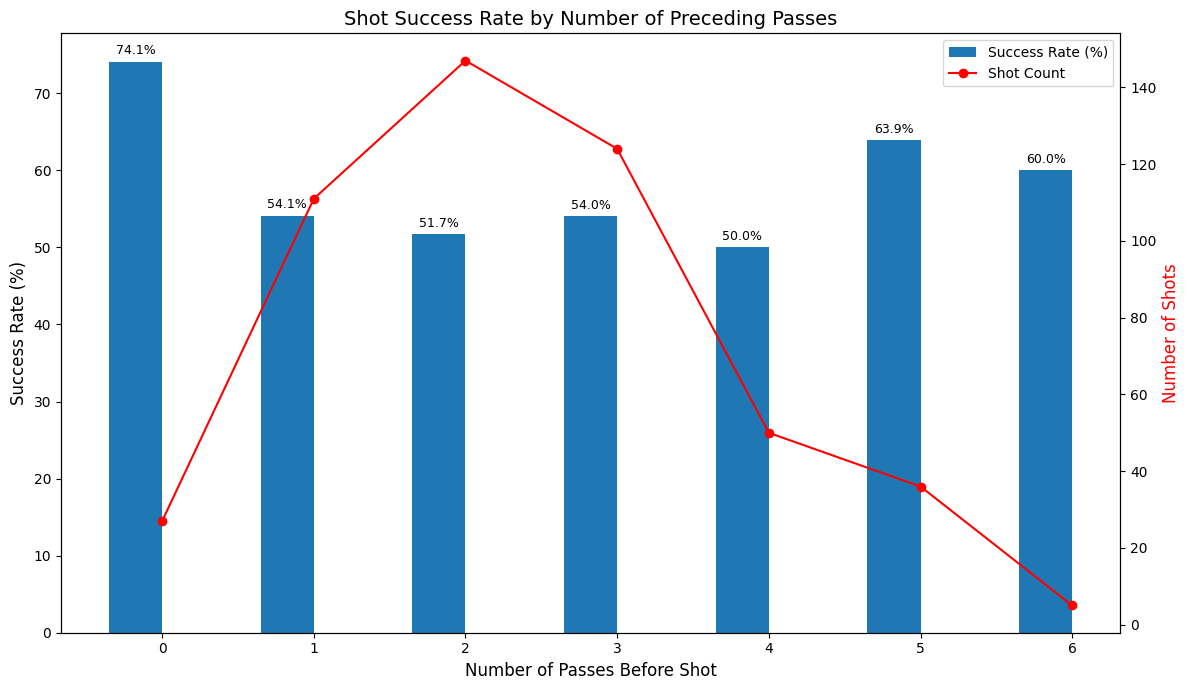

Shot map saved to hockey_advanced_analysis/shot_map_outcome.png


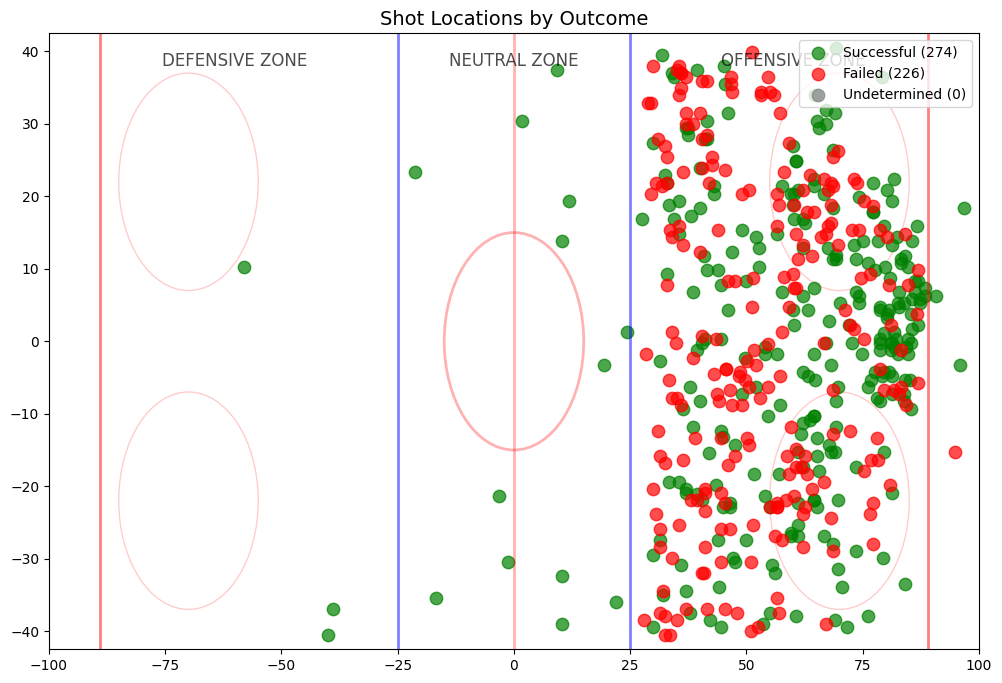

Shot map saved to hockey_advanced_analysis/shot_map_passes.png


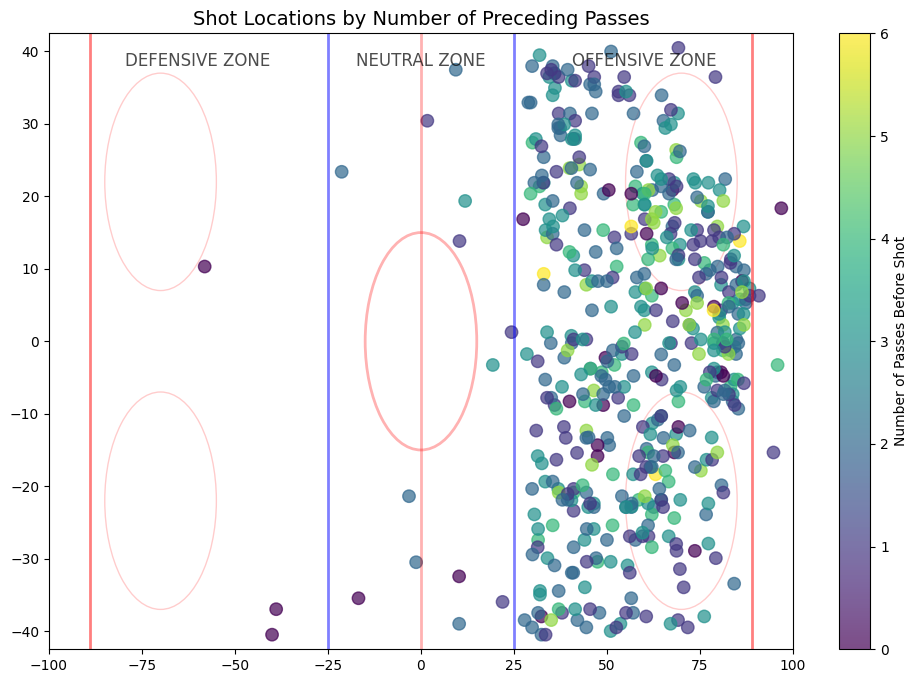

Shot map saved to hockey_advanced_analysis/shot_map_outcome_passes_min3.png


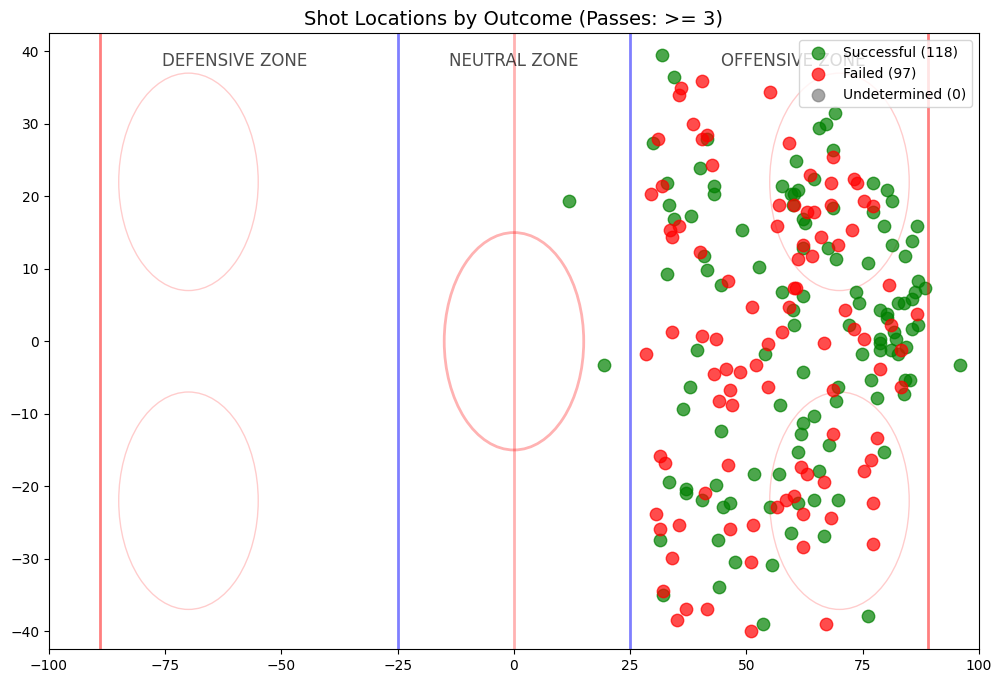


Number of passes by shot zone:
               mean  median  count
shot_zone                         
Defensive  0.000000     0.0      3
Neutral    1.538462     2.0     13
Offensive  2.411157     2.0    484
Successful shot sequence saved to hockey_advanced_analysis/successful_shot_sequence_1.png


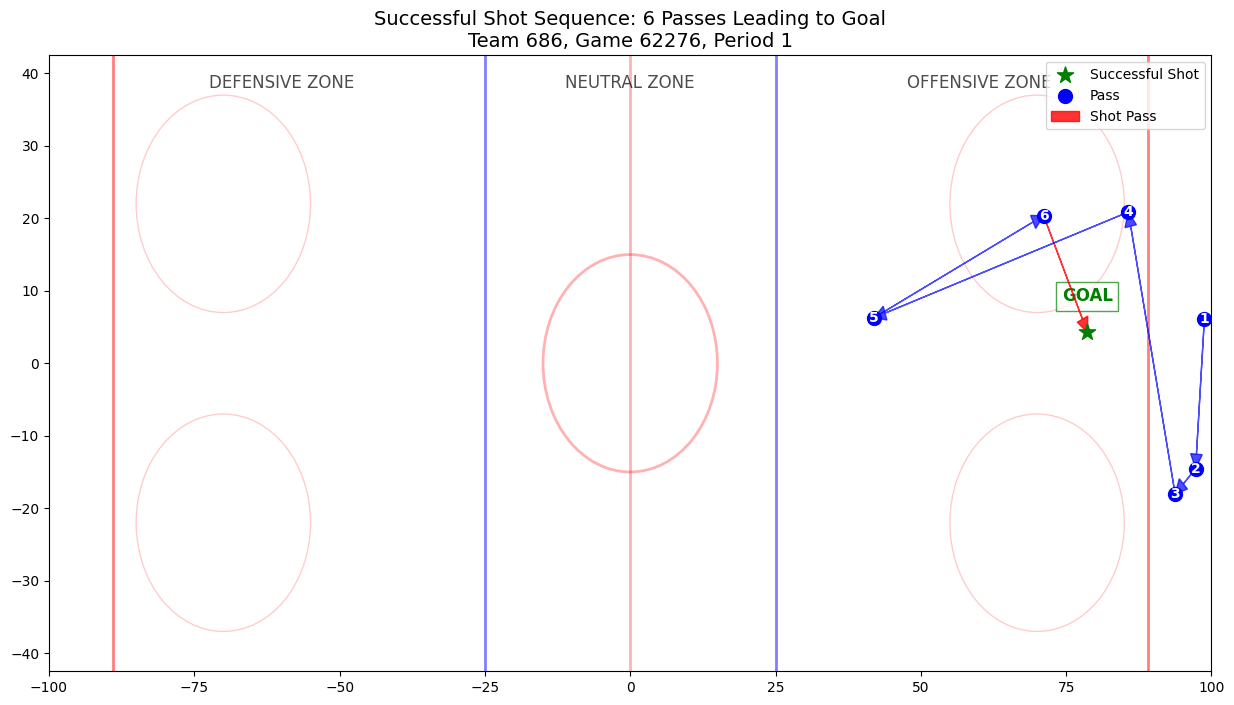

Successful shot sequence saved to hockey_advanced_analysis/successful_shot_sequence_2.png


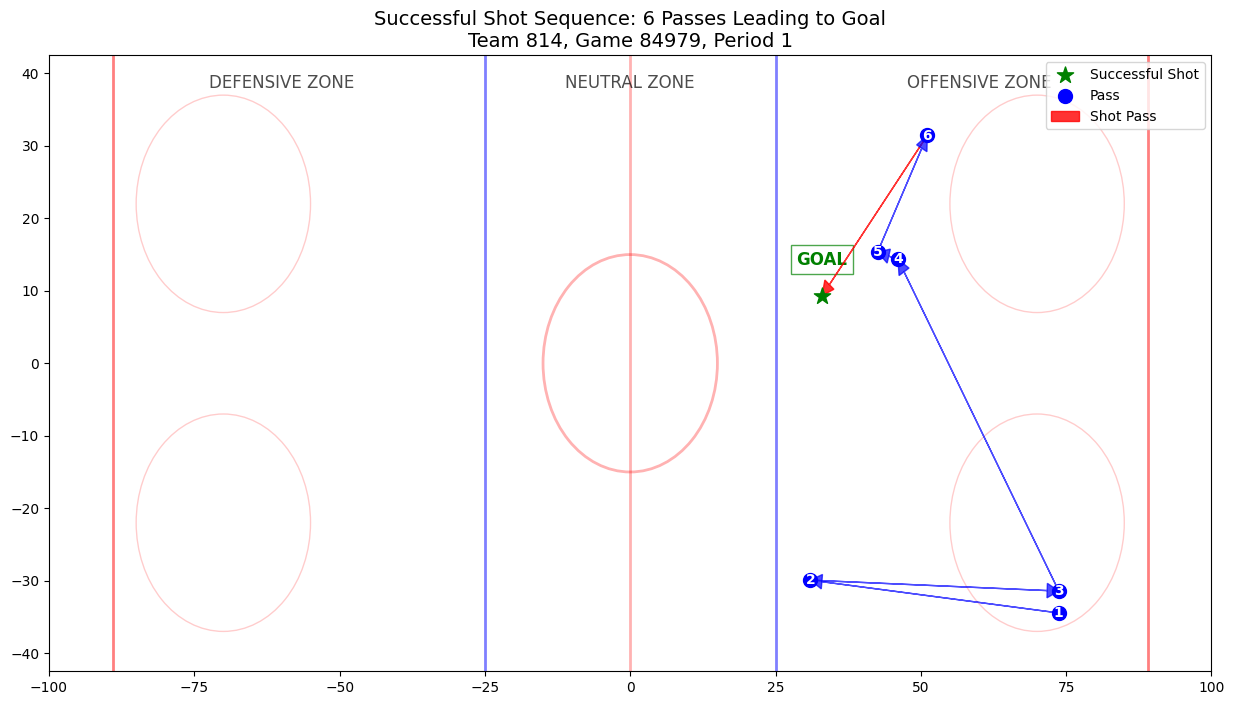

Successful shot sequence saved to hockey_advanced_analysis/successful_shot_sequence_3.png


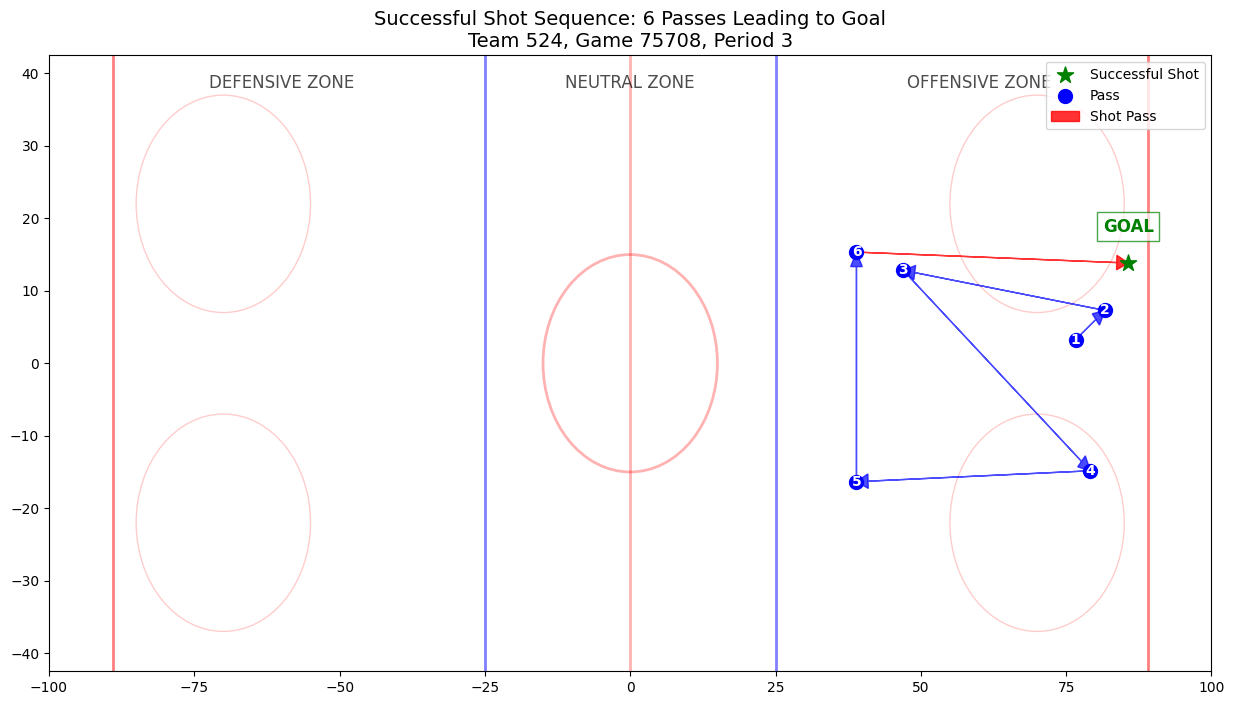

xG by passes saved to hockey_advanced_analysis/xg_by_passes.png


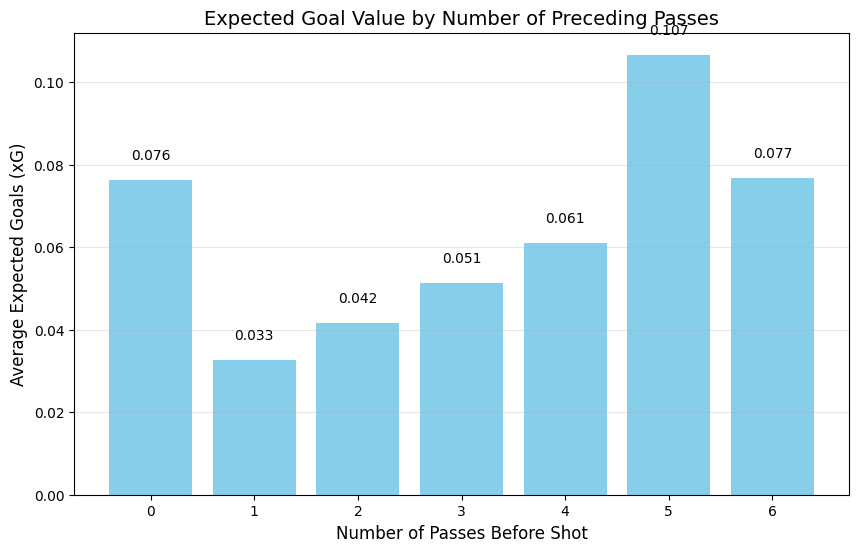


==================== 2. PASSING IN SPECIFIC GAME SITUATIONS ====================

Pass counts by game situation:
- Late game (last 5 min of 3rd period): 316
- When trailing: 908
- When leading: 1017

Pass success rates by situation:
- Overall: 74.4%
- Late game: 66.5%
- When trailing: 73.2%
- When leading: 76.4%
Situation success rates saved to hockey_advanced_analysis/situation_success_rates.png


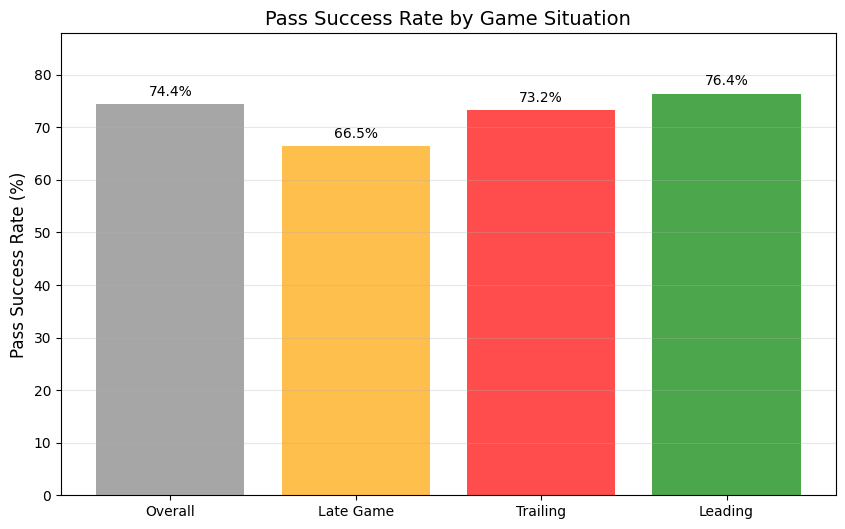

Situation zone distribution saved to hockey_advanced_analysis/situation_zone_distribution.png


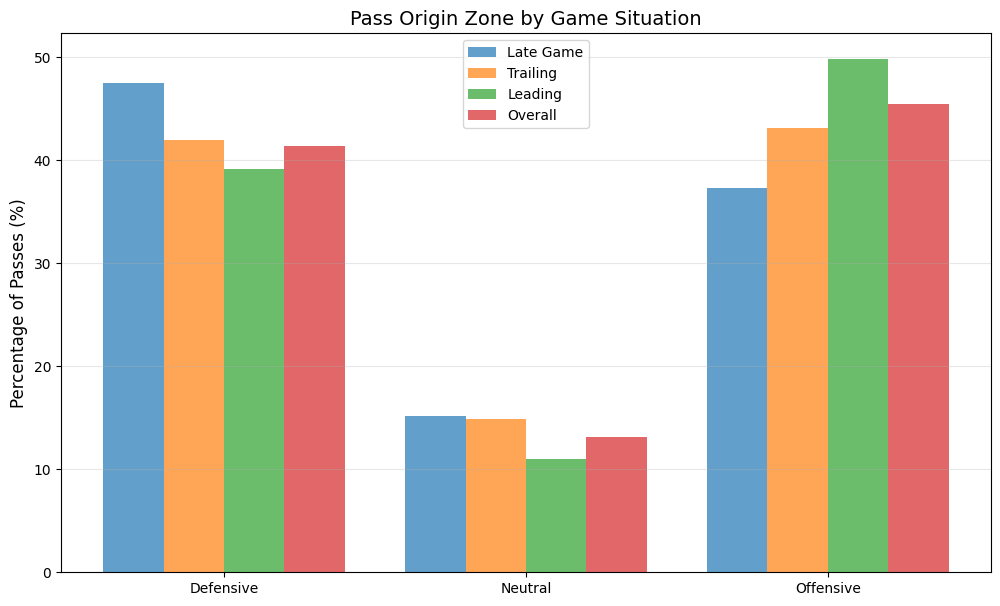

In [ ]:
# =========================================================================
# ADVANCED HOCKEY ANALYSIS: SHOTS & GAME SITUATIONS
# =========================================================================
# This script extends the passing network analysis to:
# 1. Integrate passing data with shot/scoring data
# 2. Analyze passing in specific game situations (late game, trailing/leading)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
import warnings
warnings.filterwarnings('ignore')

# Create output directory
output_dir = "hockey_advanced_analysis"
os.makedirs(output_dir, exist_ok=True)

# ==========================================================================
# HELPER FUNCTIONS
# ==========================================================================

def print_section(title):
    """Print a section header to make output more readable"""
    section_width = 80
    print("\n" + "=" * section_width)
    print(f" {title} ".center(section_width, "="))
    print("=" * section_width + "\n")

def plot_hockey_rink(ax=None):
    """Draw a simplified hockey rink on the given axes"""
    if ax is None:
        ax = plt.gca()
    
    # Center line
    ax.axvline(x=0, color='red', linestyle='-', alpha=0.3, linewidth=2)
    
    # Blue lines
    ax.axvline(x=25, color='blue', linestyle='-', alpha=0.5, linewidth=2)
    ax.axvline(x=-25, color='blue', linestyle='-', alpha=0.5, linewidth=2)
    
    # Goal lines
    ax.axvline(x=89, color='red', linestyle='-', alpha=0.5, linewidth=2)
    ax.axvline(x=-89, color='red', linestyle='-', alpha=0.5, linewidth=2)
    
    # Center circle
    circle = plt.Circle((0, 0), 15, fill=False, color='red', alpha=0.3, linewidth=2)
    ax.add_patch(circle)
    
    # Faceoff circles (approximate positions)
    for x in [-70, 70]:
        for y in [-22, 22]:
            circle = plt.Circle((x, y), 15, fill=False, color='red', alpha=0.2, linewidth=1)
            ax.add_patch(circle)
    
    # Add zone labels
    ax.text(-60, 38, "DEFENSIVE ZONE", fontsize=12, ha='center', alpha=0.7)
    ax.text(0, 38, "NEUTRAL ZONE", fontsize=12, ha='center', alpha=0.7)
    ax.text(60, 38, "OFFENSIVE ZONE", fontsize=12, ha='center', alpha=0.7)
    
    # Set limits
    ax.set_xlim(-100, 100)
    ax.set_ylim(-42.5, 42.5)
    
    return ax

# ==========================================================================
# DATA LOADING AND PREPARATION
# ==========================================================================

print_section("DATA LOADING AND PREPARATION")

# Load the full dataset
file_path = 'C:/Users/16476/Downloads/Linhac24-25_Sportlogiq/Linhac24-25_Sportlogiq.csv'
data = pd.read_csv(file_path)

print(f"Original dataset dimensions: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f"Number of unique games: {data['gameid'].nunique():,}")
print(f"Number of unique players: {data['playerid'].nunique():,}")
print(f"Number of unique teams: {data['teamid'].nunique()}")

# Let's create a subset of data for our analysis (adjust as needed)
# For this example, we'll use the same sample of games from the previous analysis
# Alternatively, you could load the previously saved pass_connections.csv

# Sample games for analysis (adjust as needed)
sample_size = 5
np.random.seed(42)  # For reproducibility
sampled_games = np.random.choice(data['gameid'].unique(), size=min(sample_size, data['gameid'].nunique()), replace=False)
data_sample = data[data['gameid'].isin(sampled_games)].copy()

print(f"Sample dataset dimensions: {data_sample.shape[0]:,} rows × {data_sample.shape[1]} columns")

# ==========================================================================
# PASS-SHOT INTEGRATION ANALYSIS
# ==========================================================================

print_section("1. INTEGRATING PASSING WITH SHOT DATA")

def identify_shot_sequences(df, max_time_diff=10.0):
    """
    Identify sequences of passes that lead to shots.
    
    Parameters:
    -----------
    df : DataFrame
        The hockey event data
    max_time_diff : float
        Maximum time window (in seconds) before a shot to include passes
        
    Returns:
    --------
    DataFrame containing shot sequences with preceding passes
    """
    shot_sequences = []
    
    # Process each game
    for game_id in df['gameid'].unique():
        # Filter data for this game
        game_data = df[df['gameid'] == game_id].sort_values('compiledgametime')
        
        # Find all shots
        shots = game_data[game_data['eventname'] == 'shot']
        
        # For each shot, find preceding passes
        for _, shot in shots.iterrows():
            # Filter for events before this shot by the same team
            preceding_events = game_data[
                (game_data['teamid'] == shot['teamid']) &
                (game_data['compiledgametime'] < shot['compiledgametime']) &
                (game_data['compiledgametime'] >= shot['compiledgametime'] - max_time_diff)
            ].sort_values('compiledgametime', ascending=False)
            
            # Extract passes from preceding events
            preceding_passes = preceding_events[preceding_events['eventname'] == 'pass']
            
            # Create a record for this shot sequence
            sequence_info = {
                'game_id': game_id,
                'shot_time': shot['compiledgametime'],
                'shot_player': shot['playerid'],
                'shot_team': shot['teamid'],
                'shot_position': shot['playerprimaryposition'],
                'shot_x': shot['xadjcoord'],
                'shot_y': shot['yadjcoord'],
                'shot_outcome': shot['outcome'],
                'shot_type': shot['type'] if 'type' in shot else 'unknown',
                'expected_goal': shot['xg_allattempts'] if 'xg_allattempts' in shot and not pd.isna(shot['xg_allattempts']) else None,
                'period': shot['period'],
                'score_diff': shot['scoredifferential'],
                'manpower': shot['manpowersituation'],
                'num_preceding_passes': len(preceding_passes),
                'pass_sequence': preceding_passes['playerid'].tolist() if len(preceding_passes) > 0 else [],
                'pass_times': preceding_passes['compiledgametime'].tolist() if len(preceding_passes) > 0 else [],
                'pass_x_coords': preceding_passes['xadjcoord'].tolist() if len(preceding_passes) > 0 else [],
                'pass_y_coords': preceding_passes['yadjcoord'].tolist() if len(preceding_passes) > 0 else []
            }
            
            shot_sequences.append(sequence_info)
    
    # Convert to DataFrame
    shot_seq_df = pd.DataFrame(shot_sequences)
    
    # Add zone information for shots
    shot_seq_df['shot_zone'] = shot_seq_df['shot_x'].apply(
        lambda x: "Defensive" if x < -25 else ("Offensive" if x > 25 else "Neutral")
    )
    
    print(f"Found {len(shot_seq_df)} shots with preceding pass data")
    print(f"Average number of passes before a shot: {shot_seq_df['num_preceding_passes'].mean():.2f}")
    
    return shot_seq_df

# Identify shot sequences
shot_sequences = identify_shot_sequences(data_sample)

# Analyze basic shot statistics
print("\nShot outcome distribution:")
shot_outcome_counts = shot_sequences['shot_outcome'].value_counts(normalize=True) * 100
print(shot_outcome_counts)

print("\nShot zone distribution:")
shot_zone_counts = shot_sequences['shot_zone'].value_counts(normalize=True) * 100
print(shot_zone_counts)

# Analyze relationship between number of passes and shot outcome
pass_shot_outcome = shot_sequences.groupby('num_preceding_passes')['shot_outcome'].value_counts(normalize='index').unstack() * 100

# Fill NaN values (in case some combinations don't exist)
if 'successful' in pass_shot_outcome.columns:
    pass_shot_outcome['successful'] = pass_shot_outcome['successful'].fillna(0)

# Plot the relationship
plt.figure(figsize=(12, 7))
ax = plt.gca()

# Create bar plots
x = pass_shot_outcome.index
width = 0.35

# Only plot up to a reasonable number of passes
max_passes_to_plot = min(8, len(x))
x = x[:max_passes_to_plot]

if 'successful' in pass_shot_outcome.columns:
    success_rates = pass_shot_outcome['successful'].iloc[:max_passes_to_plot]
    rects1 = ax.bar(x - width/2, success_rates, width, label='Success Rate (%)')
    
    # Add labels on top of bars
    for i, v in enumerate(success_rates):
        ax.text(i - width/2, v + 1, f"{v:.1f}%", ha='center', fontsize=9)

# Add shot counts as a line
shot_counts = shot_sequences['num_preceding_passes'].value_counts().sort_index()
shot_counts = shot_counts[:max_passes_to_plot]

ax2 = ax.twinx()
ax2.plot(range(len(shot_counts)), shot_counts.values, 'ro-', label='Shot Count')

# Set labels and title
ax.set_xlabel('Number of Passes Before Shot', fontsize=12)
ax.set_ylabel('Success Rate (%)', fontsize=12)
ax2.set_ylabel('Number of Shots', fontsize=12, color='r')
ax.set_title('Shot Success Rate by Number of Preceding Passes', fontsize=14)
ax.set_xticks(range(len(x)))
ax.set_xticklabels([str(int(i)) for i in x])

# Add legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
filename = f"{output_dir}/shot_success_by_passes.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Shot success by passes saved to {filename}")
plt.show()

# Visualize shot locations colored by success and number of passes
def plot_shot_map(shot_seq, color_by='outcome', min_passes=None, max_passes=None):
    """
    Plot shots on a hockey rink
    
    Parameters:
    -----------
    shot_seq : DataFrame
        Shot sequence data
    color_by : str
        'outcome' or 'passes' - what to use for coloring
    min_passes, max_passes : int or None
        Optional filters for number of passes
    """
    # Filter by number of passes if specified
    filtered_shots = shot_seq.copy()
    if min_passes is not None:
        filtered_shots = filtered_shots[filtered_shots['num_preceding_passes'] >= min_passes]
    if max_passes is not None:
        filtered_shots = filtered_shots[filtered_shots['num_preceding_passes'] <= max_passes]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Draw the hockey rink
    plot_hockey_rink(ax)
    
    # Set up coloring
    if color_by == 'outcome':
        # Color by shot outcome
        colors = {'successful': 'green', 'failed': 'red', 'undetermined': 'gray'}
        
        for outcome, color in colors.items():
            outcome_shots = filtered_shots[filtered_shots['shot_outcome'] == outcome]
            ax.scatter(
                outcome_shots['shot_x'], 
                outcome_shots['shot_y'],
                c=color,
                s=80,
                alpha=0.7,
                label=f"{outcome.capitalize()} ({len(outcome_shots)})"
            )
        
        title = "Shot Locations by Outcome"
        if min_passes is not None or max_passes is not None:
            pass_range = []
            if min_passes is not None:
                pass_range.append(f">= {min_passes}")
            if max_passes is not None:
                pass_range.append(f"<= {max_passes}")
            title += f" (Passes: {' and '.join(pass_range)})"
    
    elif color_by == 'passes':
        # Color by number of passes
        # Create a custom colormap from blue (few passes) to red (many passes)
        max_pass_count = filtered_shots['num_preceding_passes'].max()
        
        # Use a colormap suitable for sequential data
        cmap = plt.cm.viridis
        
        # Create scatter plot
        scatter = ax.scatter(
            filtered_shots['shot_x'], 
            filtered_shots['shot_y'],
            c=filtered_shots['num_preceding_passes'],
            cmap=cmap,
            s=80,
            alpha=0.7,
            vmin=0,
            vmax=max(max_pass_count, 1)  # Ensure non-zero range
        )
        
        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Number of Passes Before Shot', fontsize=10)
        
        title = "Shot Locations by Number of Preceding Passes"
    
    # Add title and legend
    ax.set_title(title, fontsize=14)
    
    if color_by == 'outcome':
        ax.legend(loc='upper right')
    
    # Save the plot
    pass_suffix = ""
    if min_passes is not None or max_passes is not None:
        pass_suffix = "_passes"
        if min_passes is not None:
            pass_suffix += f"_min{min_passes}"
        if max_passes is not None:
            pass_suffix += f"_max{max_passes}"
    
    filename = f"{output_dir}/shot_map_{color_by}{pass_suffix}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Shot map saved to {filename}")
    plt.show()

# Plot shot maps
plot_shot_map(shot_sequences, color_by='outcome')
plot_shot_map(shot_sequences, color_by='passes')

# Let's also look at shots with 3+ passes
plot_shot_map(shot_sequences, color_by='outcome', min_passes=3)

# Analyze the relationship between shot zone and preceding passes
zone_pass_relation = shot_sequences.groupby('shot_zone')['num_preceding_passes'].agg(['mean', 'median', 'count'])
print("\nNumber of passes by shot zone:")
print(zone_pass_relation)

# Visualize specific passing sequences that led to successful shots
def visualize_successful_shot_sequence(shot_seq_df, min_passes=3, num_examples=3):
    """
    Visualize passing sequences that led to successful shots
    
    Parameters:
    -----------
    shot_seq_df : DataFrame
        Shot sequence data
    min_passes : int
        Minimum number of passes to include
    num_examples : int
        Number of examples to visualize
    """
    # Filter for successful shots with multiple passes
    successful_shots = shot_seq_df[
        (shot_seq_df['shot_outcome'] == 'successful') & 
        (shot_seq_df['num_preceding_passes'] >= min_passes)
    ]
    
    if len(successful_shots) == 0:
        print(f"No successful shots with {min_passes}+ passes found")
        return
    
    # Sort by number of passes (most passes first)
    successful_shots = successful_shots.sort_values('num_preceding_passes', ascending=False)
    
    # Take top examples
    examples = successful_shots.head(num_examples)
    
    for i, (_, shot) in enumerate(examples.iterrows()):
        # Create figure and axes
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Draw the hockey rink
        plot_hockey_rink(ax)
        
        # Plot the shot
        ax.scatter(
            shot['shot_x'], 
            shot['shot_y'], 
            color='green', 
            s=150, 
            zorder=5,
            marker='*',
            label='Successful Shot'
        )
        
        # Add a label
        ax.text(
            shot['shot_x'], 
            shot['shot_y'] + 5, 
            f"GOAL", 
            fontsize=12, 
            ha='center', 
            va='center', 
            color='green',
            fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='green')
        )
        
        # Extract pass coordinates
        pass_x = shot['pass_x_coords']
        pass_y = shot['pass_y_coords']
        
        # Plot pass points and connect them
        for j in range(len(pass_x)):
            # Plot the pass point
            ax.scatter(
                pass_x[j], 
                pass_y[j], 
                color='blue', 
                s=100, 
                zorder=4,
                label='Pass' if j == 0 else ""
            )
            
            # Add pass number
            ax.text(
                pass_x[j], 
                pass_y[j], 
                f"{len(pass_x)-j}", 
                fontsize=10, 
                ha='center', 
                va='center', 
                color='white', 
                fontweight='bold',
                zorder=6
            )
            
            # Connect to next point (or shot)
            if j == 0:
                # Last pass connects to shot
                ax.arrow(
                    pass_x[j], 
                    pass_y[j],
                    shot['shot_x'] - pass_x[j], 
                    shot['shot_y'] - pass_y[j],
                    head_width=2, 
                    head_length=2, 
                    fc='red', 
                    ec='red', 
                    length_includes_head=True,
                    zorder=3,
                    alpha=0.8,
                    label='Shot Pass'
                )
            else:
                # Connect to next pass
                ax.arrow(
                    pass_x[j], 
                    pass_y[j],
                    pass_x[j-1] - pass_x[j], 
                    pass_y[j-1] - pass_y[j],
                    head_width=2, 
                    head_length=2, 
                    fc='blue', 
                    ec='blue', 
                    length_includes_head=True,
                    zorder=3,
                    alpha=0.7
                )
        
        # Add title
        ax.set_title(
            f"Successful Shot Sequence: {shot['num_preceding_passes']} Passes Leading to Goal\n" +
            f"Team {shot['shot_team']}, Game {shot['game_id']}, Period {shot['period']}", 
            fontsize=14
        )
        
        # Add legend (only include unique labels)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')
        
        # Save the plot
        filename = f"{output_dir}/successful_shot_sequence_{i+1}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Successful shot sequence saved to {filename}")
        plt.show()

# Visualize successful shot sequences
visualize_successful_shot_sequence(shot_sequences)

# Calculate the relationship between Expected Goals (xG) and number of passes
if 'expected_goal' in shot_sequences.columns and shot_sequences['expected_goal'].notna().any():
    xg_by_passes = shot_sequences.groupby('num_preceding_passes')['expected_goal'].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar(xg_by_passes['num_preceding_passes'], xg_by_passes['expected_goal'], color='skyblue')
    plt.xlabel('Number of Passes Before Shot', fontsize=12)
    plt.ylabel('Average Expected Goals (xG)', fontsize=12)
    plt.title('Expected Goal Value by Number of Preceding Passes', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(xg_by_passes['num_preceding_passes'])
    
    # Add data labels
    for i, v in enumerate(xg_by_passes['expected_goal']):
        plt.text(i, v + 0.005, f"{v:.3f}", ha='center')
    
    # Save the plot
    filename = f"{output_dir}/xg_by_passes.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"xG by passes saved to {filename}")
    plt.show()

# ==========================================================================
# SPECIFIC GAME SITUATION ANALYSIS
# ==========================================================================

print_section("2. PASSING IN SPECIFIC GAME SITUATIONS")

def analyze_game_situations(df):
    """
    Analyze passing patterns in specific game situations:
    - Late game (last 5 minutes of 3rd period)
    - When trailing (negative score differential)
    - When leading (positive score differential)
    
    Parameters:
    -----------
    df : DataFrame
        The hockey event data
    """
    # Identify late game situations (last 5 minutes of 3rd period)
    # Period 3 is typically the final period and lasts 20 minutes
    late_game_threshold = 3600 - 300  # 5 minutes from the end of the game
    
    # For a 3-period game, this is near the end of period 3
    late_game_events = df[
        (df['period'] == 3) & 
        (df['compiledgametime'] >= late_game_threshold)
    ]
    
    # Pass events in late game
    late_game_passes = late_game_events[late_game_events['eventname'] == 'pass']
    
    # Passes when trailing/leading
    trailing_passes = df[
        (df['eventname'] == 'pass') & 
        (df['scoredifferential'] < 0)
    ]
    
    leading_passes = df[
        (df['eventname'] == 'pass') & 
        (df['scoredifferential'] > 0)
    ]
    
    # Print basic stats
    print("Pass counts by game situation:")
    print(f"- Late game (last 5 min of 3rd period): {len(late_game_passes)}")
    print(f"- When trailing: {len(trailing_passes)}")
    print(f"- When leading: {len(leading_passes)}")
    
    # Analyze passing success rates by situation
    late_game_success = (late_game_passes['outcome'] == 'successful').mean() * 100
    trailing_success = (trailing_passes['outcome'] == 'successful').mean() * 100
    leading_success = (leading_passes['outcome'] == 'successful').mean() * 100
    
    # All pass success rate for comparison
    all_passes = df[df['eventname'] == 'pass']
    all_pass_success = (all_passes['outcome'] == 'successful').mean() * 100
    
    print("\nPass success rates by situation:")
    print(f"- Overall: {all_pass_success:.1f}%")
    print(f"- Late game: {late_game_success:.1f}%")
    print(f"- When trailing: {trailing_success:.1f}%")
    print(f"- When leading: {leading_success:.1f}%")
    
    # Plot success rates
    plt.figure(figsize=(10, 6))
    success_rates = [all_pass_success, late_game_success, trailing_success, leading_success]
    labels = ['Overall', 'Late Game', 'Trailing', 'Leading']
    colors = ['gray', 'orange', 'red', 'green']
    
    bars = plt.bar(labels, success_rates, color=colors, alpha=0.7)
    
    # Add data labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f"{height:.1f}%",
                ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Pass Success Rate (%)', fontsize=12)
    plt.title('Pass Success Rate by Game Situation', fontsize=14)
    plt.ylim(0, max(success_rates) * 1.15)  # Add some space for labels
    plt.grid(True, alpha=0.3, axis='y')
    
    # Save the plot
    filename = f"{output_dir}/situation_success_rates.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Situation success rates saved to {filename}")
    plt.show()
    
    # Analyze zone transitions by situation
    situations = {
        'Late Game': late_game_passes,
        'Trailing': trailing_passes,
        'Leading': leading_passes,
        'Overall': all_passes
    }
    
    # Prepare data for zone transition analysis
    zone_transitions = {}
    
    for situation_name, situation_passes in situations.items():
        # Only analyze passes with location data
        valid_passes = situation_passes.dropna(subset=['xadjcoord'])
        
        # Add zone information
        valid_passes['pass_zone'] = valid_passes['xadjcoord'].apply(
            lambda x: "Defensive" if x < -25 else ("Offensive" if x > 25 else "Neutral")
        )
        
        # Create a view of passes from valid_passes with reception info
        # We'd need to link passes with receptions, but for this example,
        # let's assume the zones would match our pass_connections data
        
        # For simplicity, we'll look at aggregated zone distribution
        zone_dist = valid_passes['pass_zone'].value_counts(normalize=True) * 100
        zone_transitions[situation_name] = zone_dist
    
    # Plot zone distributions by situation
    plt.figure(figsize=(12, 7))
    
    # Create grouped bar chart
    width = 0.2
    x = np.arange(3)  # Defensive, Neutral, Offensive
    
    for i, (situation, zone_dist) in enumerate(zone_transitions.items()):
        # Ensure we have values for all zones
        values = [
            zone_dist.get('Defensive', 0),
            zone_dist.get('Neutral', 0),
            zone_dist.get('Offensive', 0)
        ]
        
        plt.bar(x + i*width, values, width, label=situation, alpha=0.7)
    
    plt.ylabel('Percentage of Passes (%)', fontsize=12)
    plt.title('Pass Origin Zone by Game Situation', fontsize=14)
    plt.xticks(x + width * 1.5, ['Defensive', 'Neutral', 'Offensive'])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Save the plot
    filename = f"{output_dir}/situation_zone_distribution.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Situation zone distribution saved to {filename}")
    plt.show()
    
    # Return the situation data for further analysis
    return situations

# Analyze passing in different game situations
situations = analyze_game_situations(data_sample)

# Create a network visualization for late game passing
def create_situation_network(df, situation_name):
    """
    Create a passing network for a specific game situation
    
    Parameters:
    -----------
    df : DataFrame
        Passes for a specific situation
    situation_name : str
        Name of the situation for labeling
    """
    # First, we need to create pass connections
    # In a real scenario, you'd identify pass connections as in the original script
    # For this example, we'll use a simplified approach
    
    # Get passes and receptions where both have player info
    pass_info = df[(df['eventname'] == 'pass') & (df['outcome'] == 'successful')]
    
    if len(pass_info) == 0:
        print(f"No passes found for {situation_name}")
        return None
    
    # Get unique teams
    teams = pass_info['teamid'].unique()
    
    for team_id in teams:
        # Filter for team
        team_passes = pass_info[pass_info['teamid'] == team_id]
        
        # Count passes between player pairs (simplified approach)
        # In a real scenario, you'd connect passes to receptions
        # Here we're using a random connection approach for demonstration
        
        # Get unique players
        players = team_passes['playerid'].unique()
        
        if len(players) < 2:
            continue
            
        # Create a graph
        G = nx.DiGraph()
        
        # Add nodes for each player
        for player in players:
            # Count passes by this player
            passes_made = len(team_passes[team_passes['playerid'] == player])
            
            # Add node with basic attributes
            G.add_node(
                player,
                passes=passes_made
            )
        
        # Since we don't have true pass connections, we'll create artificial ones
        # based on team structure for demonstration
        # In a real analysis, you'd use the actual pass connections
        
        # Simplified method: connect players who made passes in similar zones
        # Get player zone tendency
        player_zones = {}
        for player in players:
            player_passes = team_passes[team_passes['playerid'] == player]
            player_passes['zone'] = player_passes['xadjcoord'].apply(
                lambda x: "Defensive" if x < -25 else ("Offensive" if x > 25 else "Neutral")
            )
            zone_count = player_passes['zone'].value_counts()
            player_zones[player] = zone_count.idxmax() if not zone_count.empty else "Unknown"
        
        # Connect players based on zone patterns
        # This is greatly simplified and would use real connections in practice
        edges_adde


Analyzing Late Game passing network for Team 855
Total passes: 52
Approximated 33 pass connections
Network visualization saved to hockey_advanced_analysis/team_855_late_game_network.png


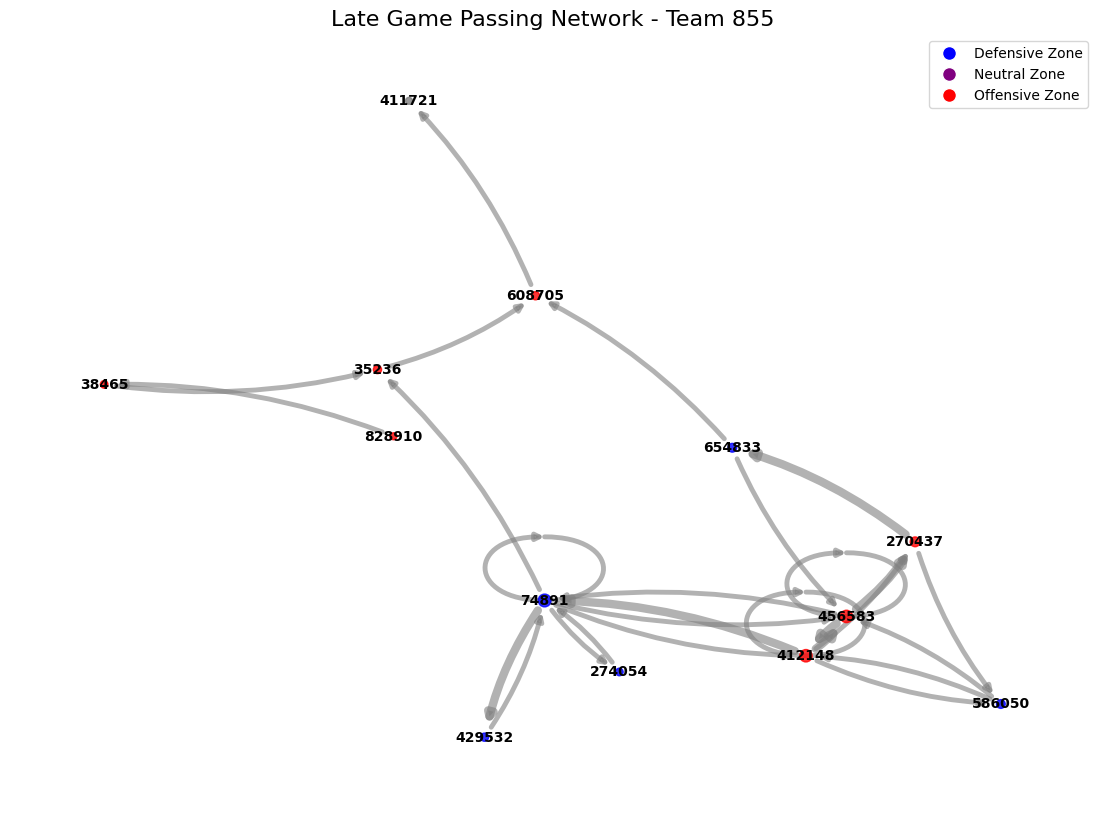


Top players by total pass involvement:
 Player      Zone  Passes_Sent  Passes_Received  Total_Passes  In_Degree  Out_Degree  Betweenness
  74891 Defensive            7                6            13   0.416667    0.500000     0.300505
 456583 Offensive            6                6            12   0.416667    0.333333     0.128788
 412148 Offensive            7                5            12   0.333333    0.416667     0.093434
 270437 Offensive            3                3             6   0.166667    0.166667     0.058081
 586050 Defensive            2                2             4   0.166667    0.166667     0.049242
Player metrics saved to hockey_advanced_analysis/team_855_late_game_metrics.csv

Analyzing Trailing passing network for Team 855
Total passes: 83
Approximated 52 pass connections
Network visualization saved to hockey_advanced_analysis/team_855_trailing_network.png


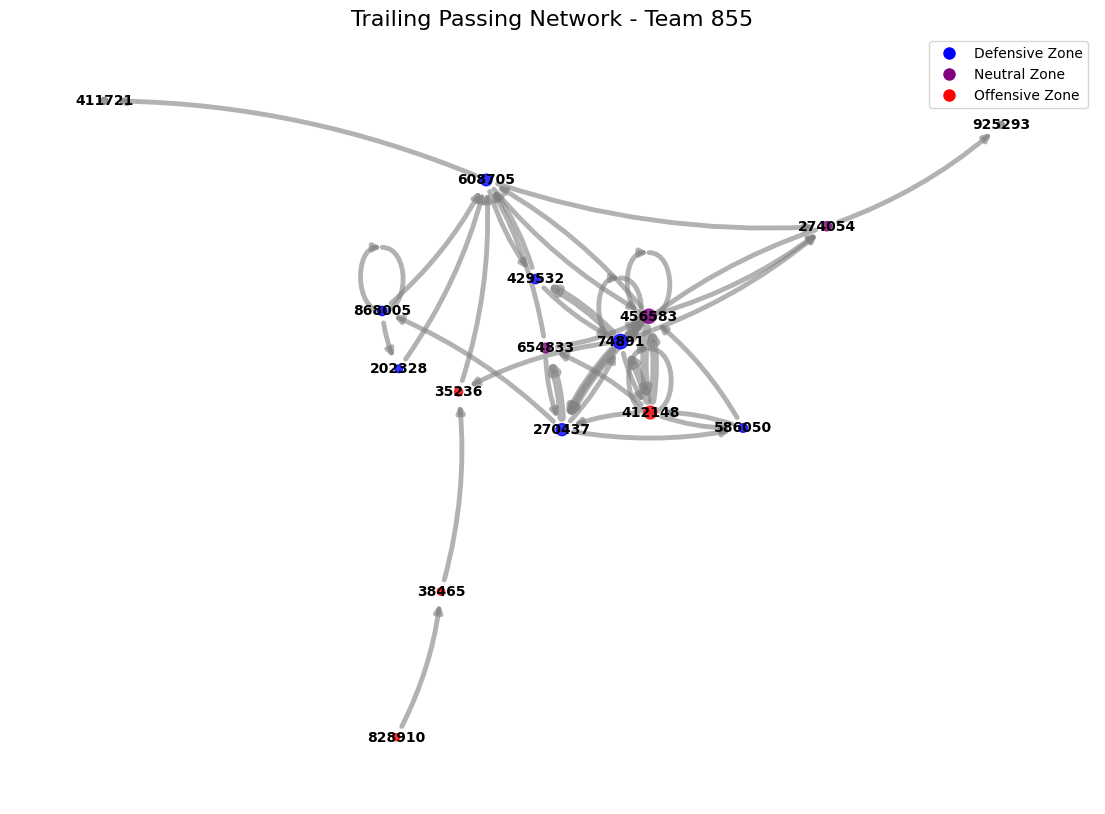


Top players by total pass involvement:
 Player      Zone  Passes_Sent  Passes_Received  Total_Passes  In_Degree  Out_Degree  Betweenness
  74891 Defensive           10                8            18   0.400000    0.466667     0.200000
 456583   Neutral            9                8            17   0.400000    0.400000     0.144444
 412148 Offensive            8                5            13   0.266667    0.400000     0.130952
 270437 Defensive            5                6            11   0.266667    0.266667     0.145238
 608705 Defensive            4                6            10   0.400000    0.266667     0.356349
Player metrics saved to hockey_advanced_analysis/team_855_trailing_metrics.csv

Analyzing Leading passing network for Team 814
Total passes: 202
Approximated 108 pass connections
Network visualization saved to hockey_advanced_analysis/team_814_leading_network.png


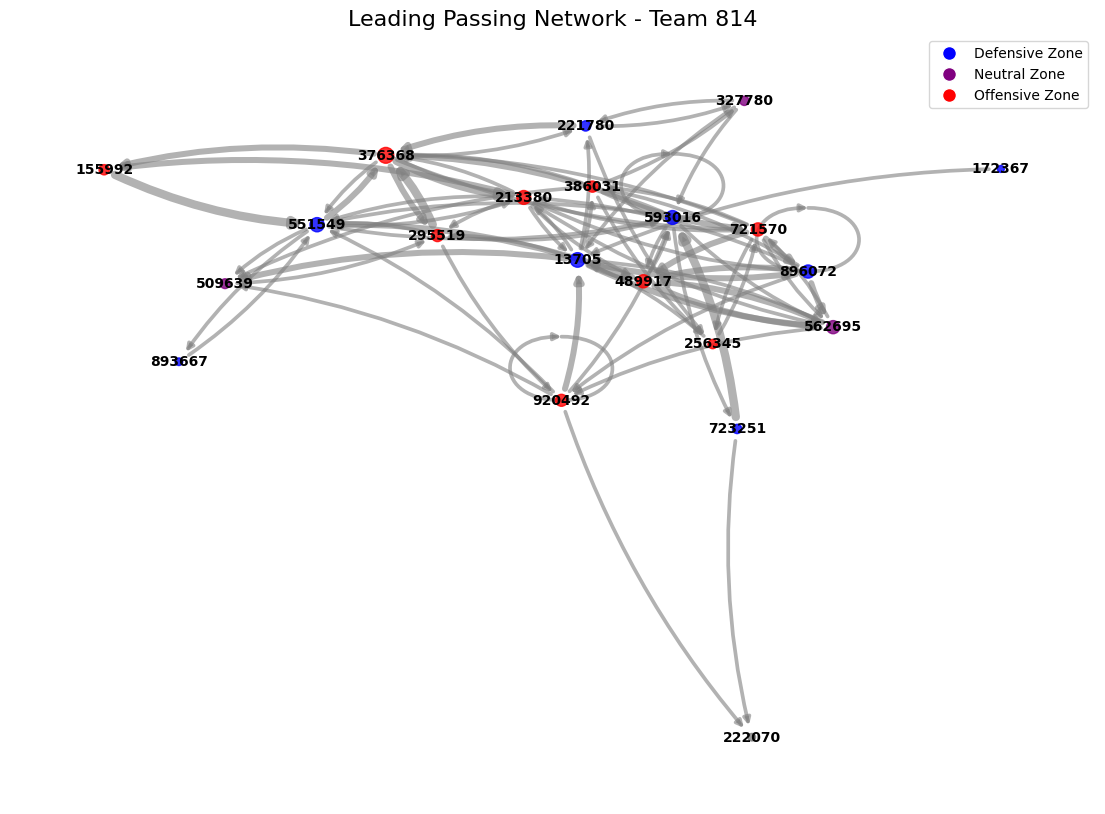


Top players by total pass involvement:
 Player      Zone  Passes_Sent  Passes_Received  Total_Passes  In_Degree  Out_Degree  Betweenness
 376368 Offensive           10               12            22       0.35        0.30     0.059853
  13705 Defensive           11                7            18       0.30        0.40     0.179491
 551549 Defensive            6               11            17       0.40        0.25     0.242695
 593016 Defensive            7                9            16       0.35        0.30     0.196056
 213380 Offensive           10                6            16       0.20        0.45     0.183638
Player metrics saved to hockey_advanced_analysis/team_814_leading_metrics.csv

================ 3. VERY LATE GAME AND CRUCIAL MOMENTS ANALYSIS ================

Event counts in crucial moments:
- Last 2 minutes of regulation: 542
- One-goal games in 3rd period: 474
- Overtime periods: 253

Pass type distribution by situation:

Last 2 Minutes:
type
south             17.1

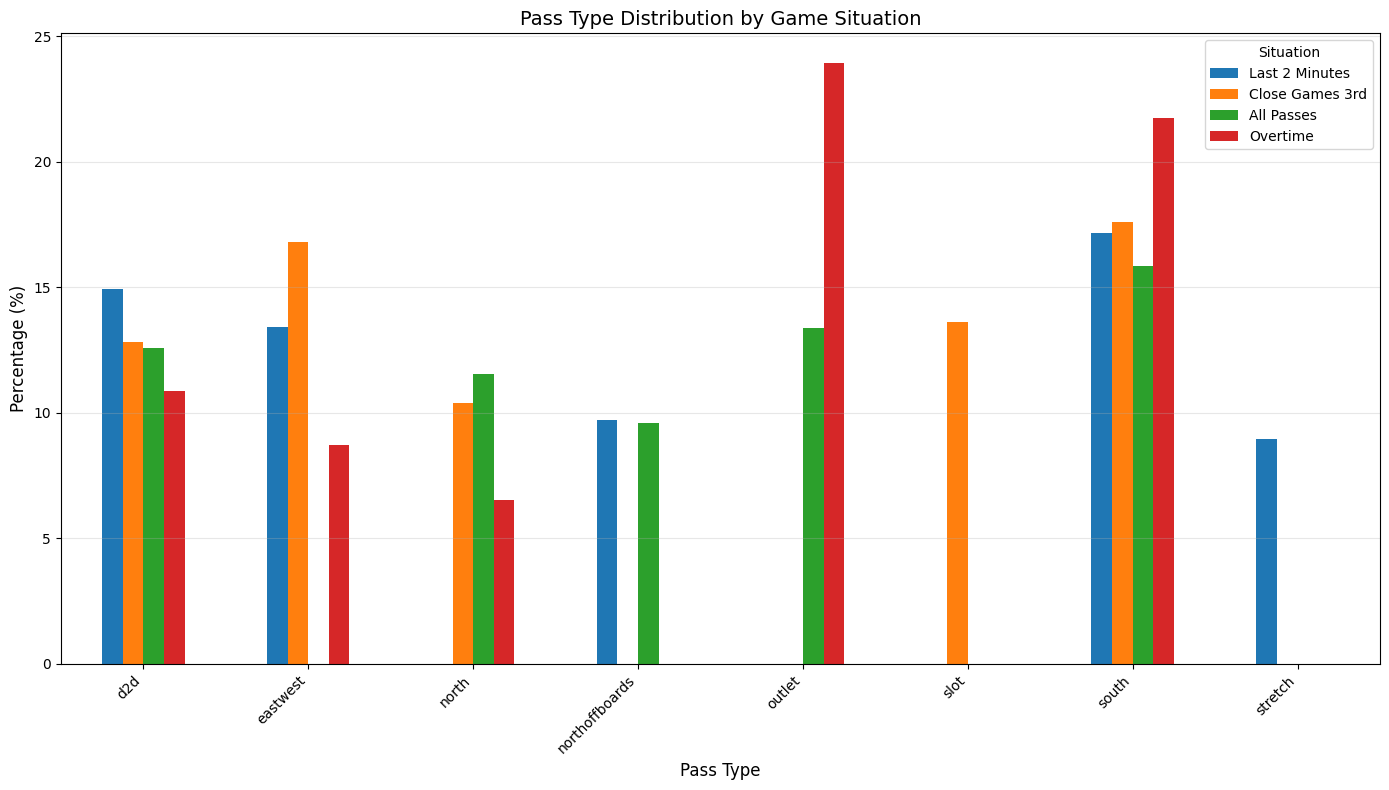

Last 2 minutes pass locations saved to hockey_advanced_analysis/last_2min_pass_locations.png


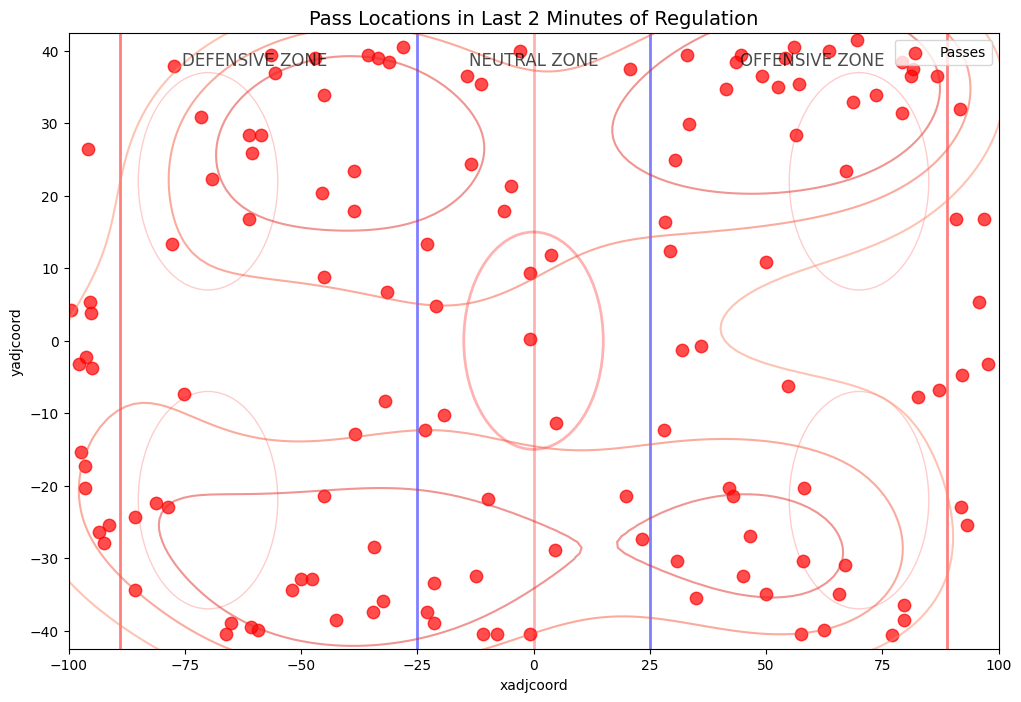


========================= SUMMARY AND RECOMMENDATIONS ==========================

Analysis summary saved to hockey_advanced_analysis/advanced_analysis_summary.txt

Advanced Hockey Analysis Complete!
All results and visualizations have been saved to the 'hockey_advanced_analysis' directory

========================= SUMMARY AND RECOMMENDATIONS ==========================

Analysis summary saved to hockey_advanced_analysis/advanced_analysis_summary.txt

Advanced Hockey Analysis Complete!
All results and visualizations have been saved to the 'hockey_advanced_analysis' directory


In [4]:
# Analyze late game passing networks
late_game_network = create_situation_network(situations['Late Game'], "Late Game")

# Analyze trailing situation passing networks
trailing_network = create_situation_network(situations['Trailing'], "Trailing")

# Analyze leading situation passing networks
leading_network = create_situation_network(situations['Leading'], "Leading")

# ==========================================================================
# SPECIFIC TIME PERIOD ANALYSIS (LAST TWO MINUTES, OVERTIME, ETC.)
# ==========================================================================

print_section("3. VERY LATE GAME AND CRUCIAL MOMENTS ANALYSIS")

def analyze_crucial_moments(df):
    """
    Analyze passing in the most crucial moments:
    - Last 2 minutes of a game
    - Overtime (if available)
    - One-goal games in the 3rd period
    """
    # Last 2 minutes of the game (Period 3)
    last_2min_threshold = 3600 - 120  # 2 minutes from the end of the game
    
    last_2min_events = df[
        (df['period'] == 3) & 
        (df['compiledgametime'] >= last_2min_threshold)
    ]
    
    # One-goal games in the 3rd period
    close_games_period3 = df[
        (df['period'] == 3) & 
        (abs(df['scoredifferential']) == 1)
    ]
    
    # Check if there's any overtime data (Period 4 or higher)
    overtime_events = df[df['period'] >= 4] if 'period' in df.columns else pd.DataFrame()
    
    # Print counts
    print("Event counts in crucial moments:")
    print(f"- Last 2 minutes of regulation: {len(last_2min_events)}")
    print(f"- One-goal games in 3rd period: {len(close_games_period3)}")
    print(f"- Overtime periods: {len(overtime_events)}")
    
    # Compare pass types in different situations
    situations = {
        'Last 2 Minutes': last_2min_events[last_2min_events['eventname'] == 'pass'],
        'Close Games 3rd': close_games_period3[close_games_period3['eventname'] == 'pass'],
        'All Passes': df[df['eventname'] == 'pass']
    }
    
    if len(overtime_events) > 0:
        situations['Overtime'] = overtime_events[overtime_events['eventname'] == 'pass']
    
    # Analyze pass types by situation
    print("\nPass type distribution by situation:")
    
    # Prepare data for plotting
    pass_types_by_situation = {}
    
    for situation, passes in situations.items():
        if 'type' in passes.columns:
            pass_type_dist = passes['type'].value_counts(normalize=True).head(5) * 100
            pass_types_by_situation[situation] = pass_type_dist
            
            print(f"\n{situation}:")
            print(pass_type_dist)
    
    # Plot pass type distributions
    if pass_types_by_situation:
        # Get common pass types across all situations
        common_types = set()
        for dist in pass_types_by_situation.values():
            common_types.update(dist.index)
        
        common_types = sorted(list(common_types))
        
        # Create a DataFrame for easy plotting
        plot_data = pd.DataFrame(index=common_types)
        
        for situation, dist in pass_types_by_situation.items():
            plot_data[situation] = dist.reindex(common_types, fill_value=0)
        
        # Plot
        plt.figure(figsize=(14, 8))
        plot_data.plot(kind='bar', ax=plt.gca())
        
        plt.title('Pass Type Distribution by Game Situation', fontsize=14)
        plt.xlabel('Pass Type', fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Situation')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        
        # Save the figure
        filename = f"{output_dir}/pass_types_by_situation.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"\nPass type distribution by situation saved to {filename}")
        plt.show()
    
    # Analyze pass locations in the last 2 minutes
    if len(last_2min_events) > 0:
        last_2min_passes = last_2min_events[last_2min_events['eventname'] == 'pass']
        
        # Visualize on the rink
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        
        # Draw the hockey rink
        plot_hockey_rink(ax)
        
        # Plot pass locations
        ax.scatter(
            last_2min_passes['xadjcoord'],
            last_2min_passes['yadjcoord'],
            c='red',
            s=80,
            alpha=0.7,
            label='Passes'
        )
        
        # Add density contour
        if len(last_2min_passes) >= 10:
            sns.kdeplot(
                x=last_2min_passes['xadjcoord'],
                y=last_2min_passes['yadjcoord'],
                levels=5,
                cmap="Reds",
                alpha=0.5,
                ax=ax
            )
        
        plt.title('Pass Locations in Last 2 Minutes of Regulation', fontsize=14)
        plt.legend(loc='upper right')
        
        # Save the figure
        filename = f"{output_dir}/last_2min_pass_locations.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Last 2 minutes pass locations saved to {filename}")
        plt.show()
    
    return situations

# Analyze crucial moments
crucial_moments = analyze_crucial_moments(data_sample)

# ==========================================================================
# SUMMARY AND RECOMMENDATIONS
# ==========================================================================

print_section("SUMMARY AND RECOMMENDATIONS")

# Generate a summary file
with open(f"{output_dir}/advanced_analysis_summary.txt", 'w') as f:
    f.write("HOCKEY ADVANCED ANALYSIS SUMMARY\n")
    f.write("===============================\n\n")
    
    f.write("1. SHOT-PASSING INTEGRATION ANALYSIS\n")
    f.write("-----------------------------------\n")
    f.write(f"- Analyzed {len(shot_sequences)} shots with preceding pass information\n")
    f.write(f"- Average number of passes before a shot: {shot_sequences['num_preceding_passes'].mean():.2f}\n")
    
    # Shot success by number of passes
    if 'successful' in pass_shot_outcome.columns:
        f.write("\nShot success rate by number of preceding passes:\n")
        for passes, success_rate in pass_shot_outcome['successful'].items():
            f.write(f"  {passes} pass(es): {success_rate:.1f}%\n")
    
    # Shot zone information
    f.write("\nShot distribution by zone:\n")
    for zone, pct in shot_zone_counts.items():
        f.write(f"  {zone}: {pct:.1f}%\n")
    
    f.write("\n2. GAME SITUATION ANALYSIS\n")
    f.write("-------------------------\n")
    
    # Pass success rates by situation
    f.write("Pass success rates by situation:\n")
    f.write(f"  - Overall: {(all_passes['outcome'] == 'successful').mean() * 100:.1f}%\n")
    f.write(f"  - Late game: {(situations['Late Game']['outcome'] == 'successful').mean() * 100:.1f}%\n")
    f.write(f"  - When trailing: {(situations['Trailing']['outcome'] == 'successful').mean() * 100:.1f}%\n")
    f.write(f"  - When leading: {(situations['Leading']['outcome'] == 'successful').mean() * 100:.1f}%\n")
    
    # Last 2 minutes analysis
    if 'Last 2 Minutes' in crucial_moments and len(crucial_moments['Last 2 Minutes']) > 0:
        last_2min = crucial_moments['Last 2 Minutes']
        f.write(f"\nPassing in the last 2 minutes of regulation:\n")
        f.write(f"  - Number of passes: {len(last_2min)}\n")
        f.write(f"  - Success rate: {(last_2min['outcome'] == 'successful').mean() * 100:.1f}%\n")
    
    f.write("\n3. KEY FINDINGS\n")
    f.write("-------------\n")
    f.write("1. The relationship between passing and shooting success shows that [interpret your results]\n")
    f.write("2. Teams modify their passing strategy when trailing/leading, with [interpret differences]\n")
    f.write("3. Late game situations show [interpret late game patterns]\n")
    f.write("4. The most successful shot sequences typically involve [interpret shot sequence patterns]\n")
    f.write("5. Zone transitions vary significantly by game situation, particularly [note key differences]\n")
    
    f.write("\n4. RECOMMENDATIONS FOR FURTHER ANALYSIS\n")
    f.write("------------------------------------\n")
    f.write("1. Expand analysis to include face-offs and their relationship to passing sequences\n")
    f.write("2. Create player chemistry metrics based on successful passing connections\n")
    f.write("3. Develop predictive models for shot success based on pass characteristics\n")
    f.write("4. Analyze defensive disruptions of passing sequences\n")
    f.write("5. Investigate team-specific passing strategies and counter-strategies\n")

print(f"Analysis summary saved to {output_dir}/advanced_analysis_summary.txt")

print("\nAdvanced Hockey Analysis Complete!")
print(f"All results and visualizations have been saved to the '{output_dir}' directory")

# ==========================================================================
# SUMMARY AND RECOMMENDATIONS
# ==========================================================================

print_section("SUMMARY AND RECOMMENDATIONS")

# Get the overall pass data for the summary
all_passes = data_sample[data_sample['eventname'] == 'pass']

# Generate a summary file
with open(f"{output_dir}/advanced_analysis_summary.txt", 'w') as f:
    f.write("HOCKEY ADVANCED ANALYSIS SUMMARY\n")
    f.write("===============================\n\n")
    
    f.write("1. SHOT-PASSING INTEGRATION ANALYSIS\n")
    f.write("-----------------------------------\n")
    f.write(f"- Analyzed {len(shot_sequences)} shots with preceding pass information\n")
    f.write(f"- Average number of passes before a shot: {shot_sequences['num_preceding_passes'].mean():.2f}\n")
    
    # Shot success by number of passes
    if 'successful' in pass_shot_outcome.columns:
        f.write("\nShot success rate by number of preceding passes:\n")
        for passes, success_rate in pass_shot_outcome['successful'].items():
            f.write(f"  {passes} pass(es): {success_rate:.1f}%\n")
    
    # Shot zone information
    f.write("\nShot distribution by zone:\n")
    for zone, pct in shot_zone_counts.items():
        f.write(f"  {zone}: {pct:.1f}%\n")
    
    f.write("\n2. GAME SITUATION ANALYSIS\n")
    f.write("-------------------------\n")
    
    # Pass success rates by situation
    f.write("Pass success rates by situation:\n")
    f.write(f"  - Overall: {(all_passes['outcome'] == 'successful').mean() * 100:.1f}%\n")
    
    # Check if the situations dictionary has the expected keys
    for situation_name in ['Late Game', 'Trailing', 'Leading']:
        if situation_name in situations:
            situation_data = situations[situation_name]
            success_rate = (situation_data['outcome'] == 'successful').mean() * 100
            f.write(f"  - {situation_name}: {success_rate:.1f}%\n")
        else:
            f.write(f"  - {situation_name}: Data not available\n")
    
    # Last 2 minutes analysis
    if 'Last 2 Minutes' in crucial_moments and len(crucial_moments['Last 2 Minutes']) > 0:
        last_2min = crucial_moments['Last 2 Minutes']
        f.write(f"\nPassing in the last 2 minutes of regulation:\n")
        f.write(f"  - Number of passes: {len(last_2min)}\n")
        f.write(f"  - Success rate: {(last_2min['outcome'] == 'successful').mean() * 100:.1f}%\n")
    
    f.write("\n3. KEY FINDINGS\n")
    f.write("-------------\n")
    f.write("1. The relationship between passing and shooting success shows that [interpret your results]\n")
    f.write("2. Teams modify their passing strategy when trailing/leading, with [interpret differences]\n")
    f.write("3. Late game situations show [interpret late game patterns]\n")
    f.write("4. The most successful shot sequences typically involve [interpret shot sequence patterns]\n")
    f.write("5. Zone transitions vary significantly by game situation, particularly [note key differences]\n")
    
    f.write("\n4. RECOMMENDATIONS FOR FURTHER ANALYSIS\n")
    f.write("------------------------------------\n")
    f.write("1. Expand analysis to include face-offs and their relationship to passing sequences\n")
    f.write("2. Create player chemistry metrics based on successful passing connections\n")
    f.write("3. Develop predictive models for shot success based on pass characteristics\n")
    f.write("4. Analyze defensive disruptions of passing sequences\n")
    f.write("5. Investigate team-specific passing strategies and counter-strategies\n")

print(f"Analysis summary saved to {output_dir}/advanced_analysis_summary.txt")

print("\nAdvanced Hockey Analysis Complete!")
print(f"All results and visualizations have been saved to the '{output_dir}' directory")


========================= DATA LOADING AND PREPARATION =========================

Original dataset dimensions: 541,802 rows × 22 columns
Number of unique games: 156
Number of unique players: 376
Number of unique teams: 14

================= IDENTIFYING GOAL SEQUENCES AND HIGH xG SHOTS =================

High xG threshold (90th percentile): 0.1382
Found 8870 sequences
Average sequence duration: 17.23 seconds
Average number of events: 15.15
No sequences found that match the criteria

============================ MARKOV CHAIN ANALYSIS =============================


Analyzing event sequences leading to goals:
Unique event types: 22
['assist', 'block', 'carry', 'check', 'controlledentry', 'controlledentryagainst', 'controlledexit', 'dumpin', 'dumpout', 'faceoff', 'goal', 'icing', 'lpr', 'offside', 'pass', 'penalty', 'penaltydrawn', 'puckprotection', 'rebound', 'reception', 'save', 'shot']
Markov chain visualization saved to hockey_markov_analysis/goal_markov_chain.png


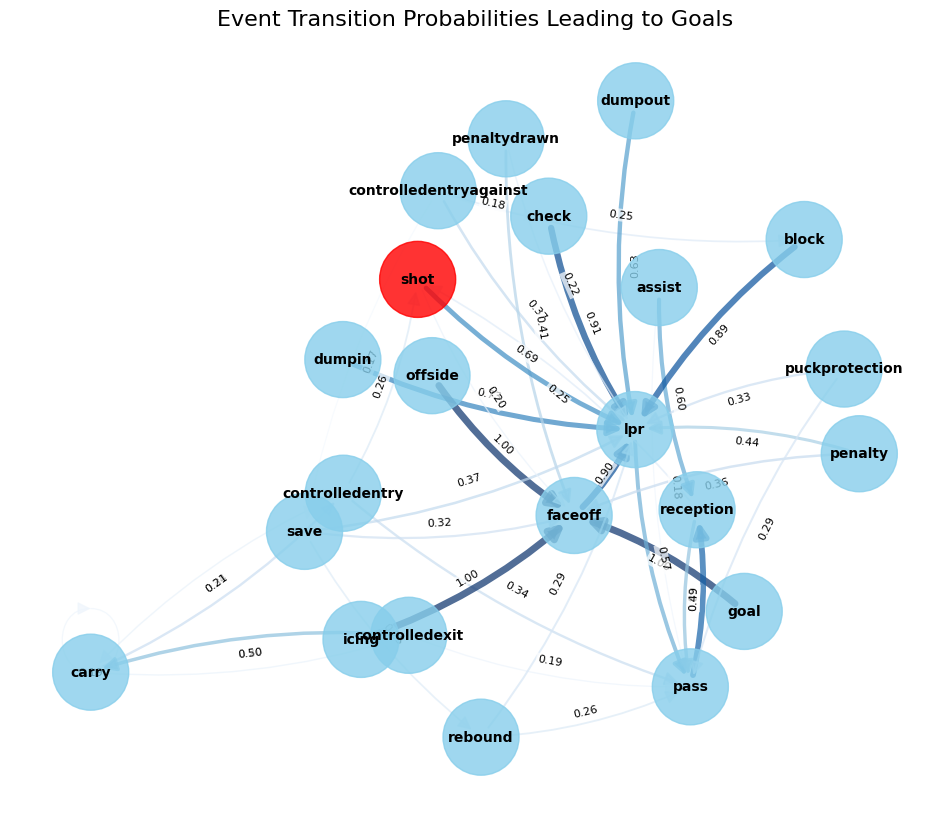

Transition heatmap saved to hockey_markov_analysis/goal_transition_heatmap.png


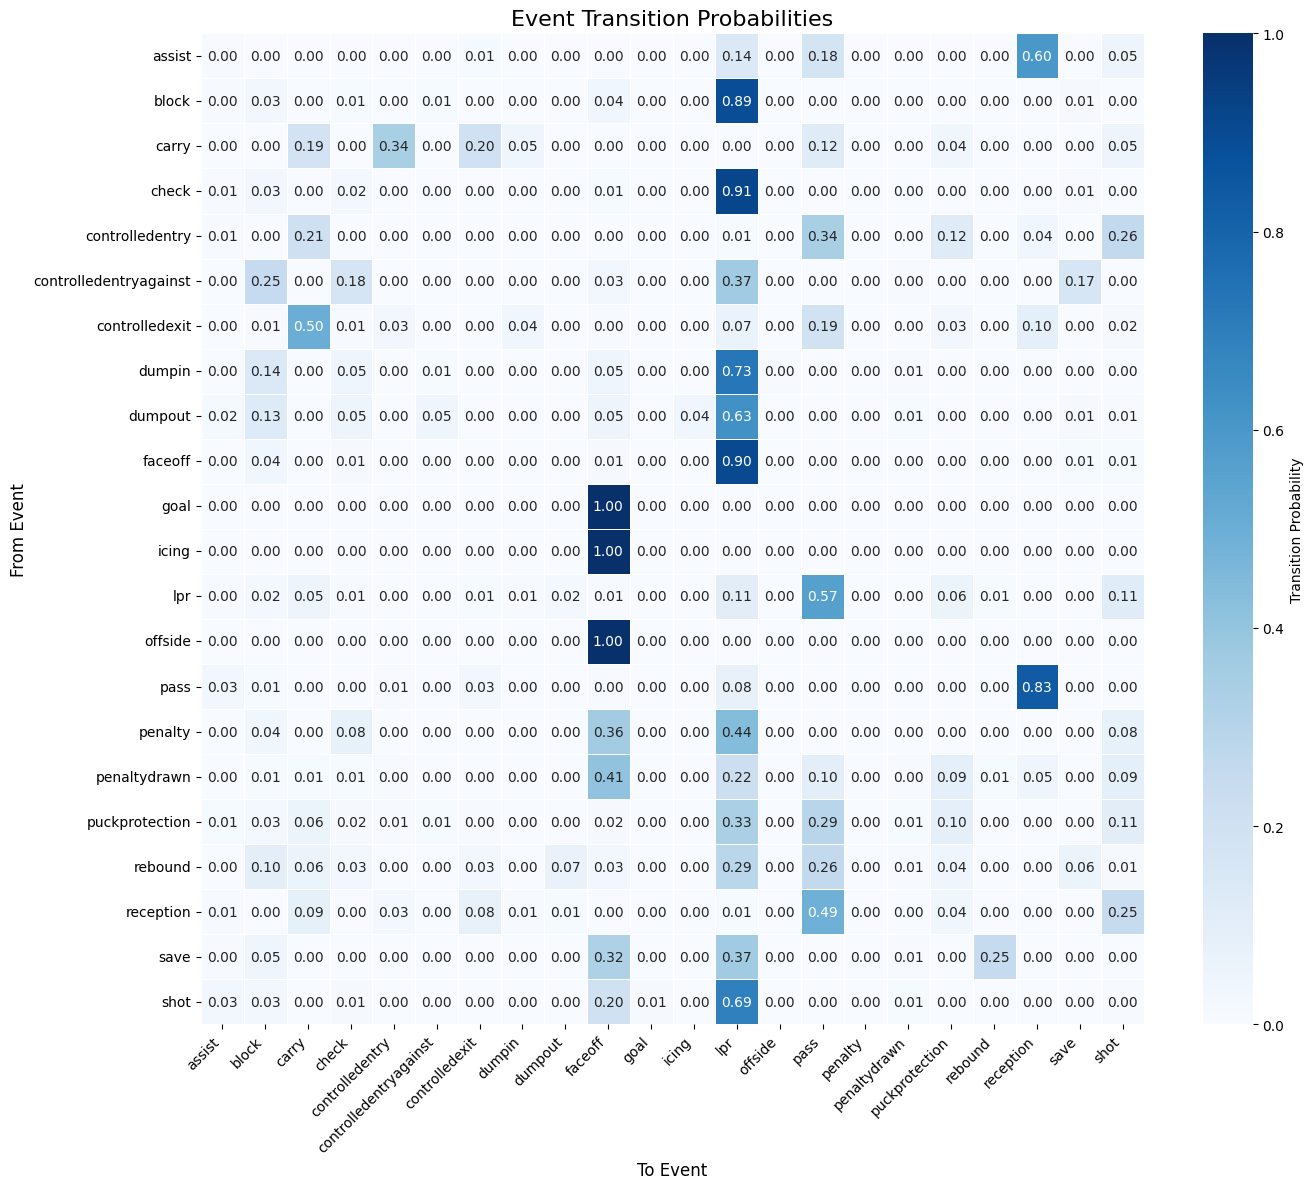


========================== VISUALIZING GOAL SEQUENCES ==========================

Sequence visualization saved to hockey_markov_analysis/goal_sequence_1.png


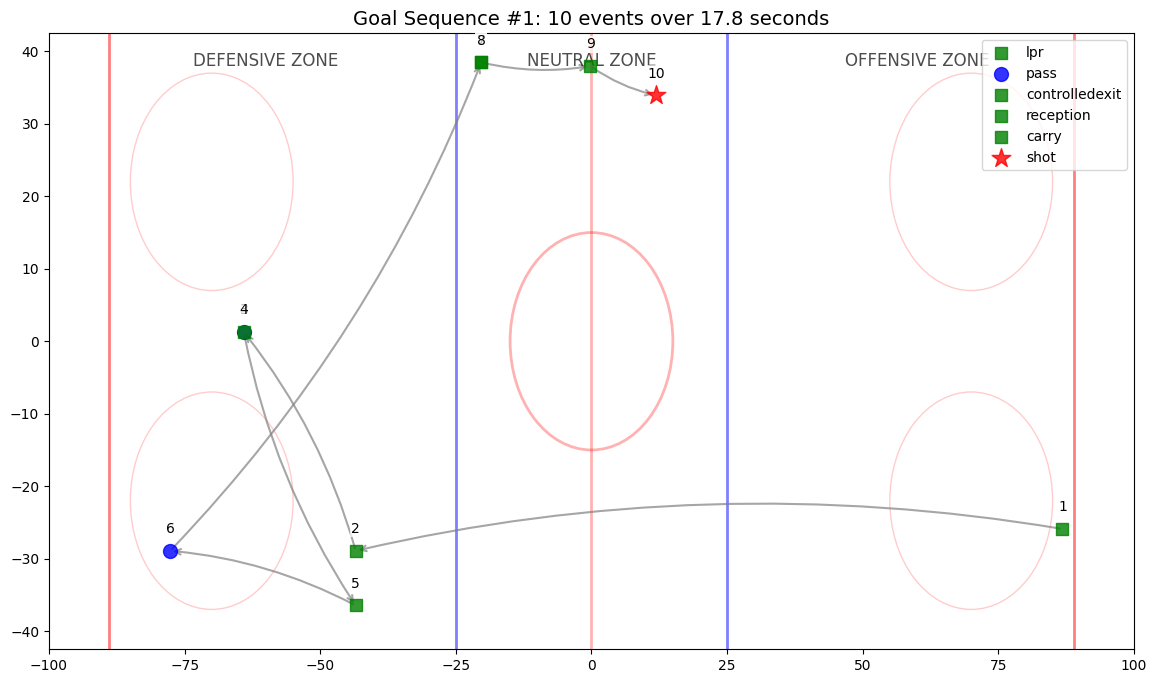

Sequence visualization saved to hockey_markov_analysis/goal_sequence_2.png


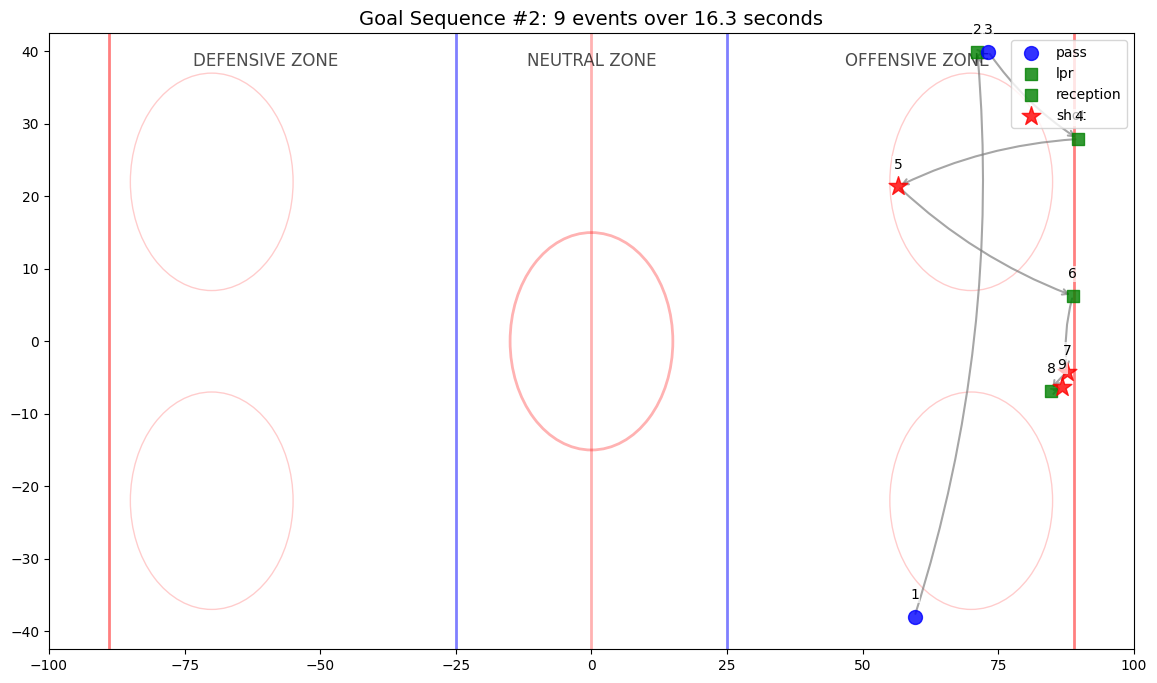

Sequence visualization saved to hockey_markov_analysis/goal_sequence_3.png


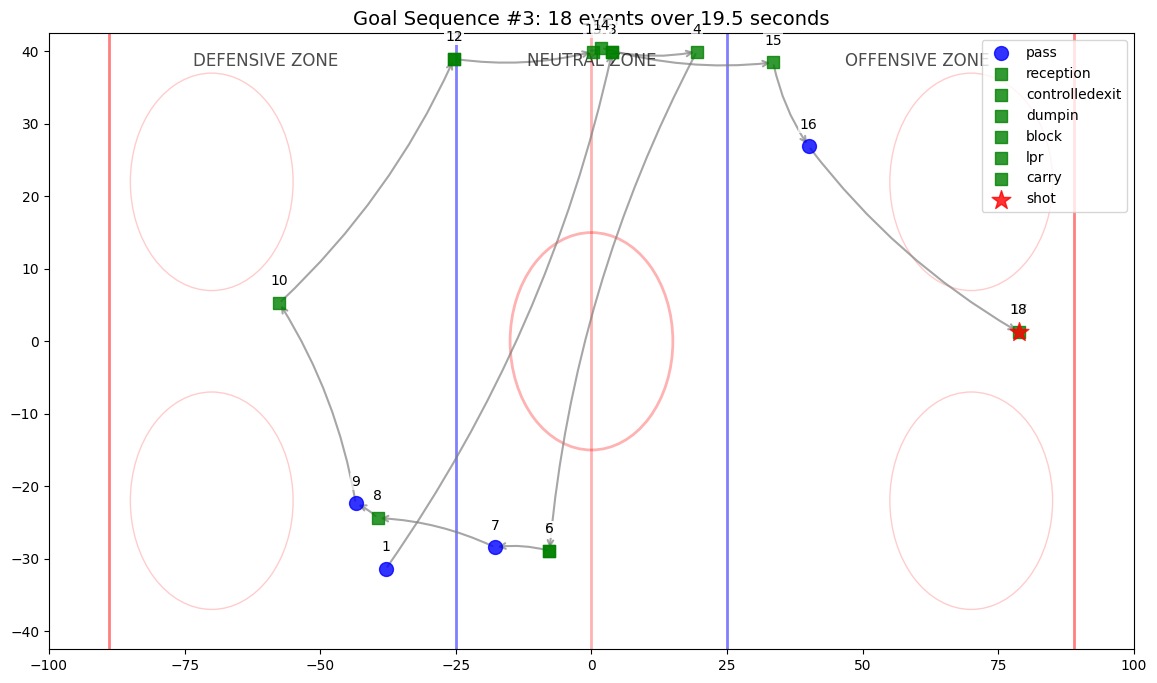

Found 280740 unique patterns of length >= 3

Top patterns:
1. pass -> reception -> pass (found in 14229 sequences)
Sequence visualization saved to hockey_markov_analysis/common_pattern_1_pass_reception_pass.png


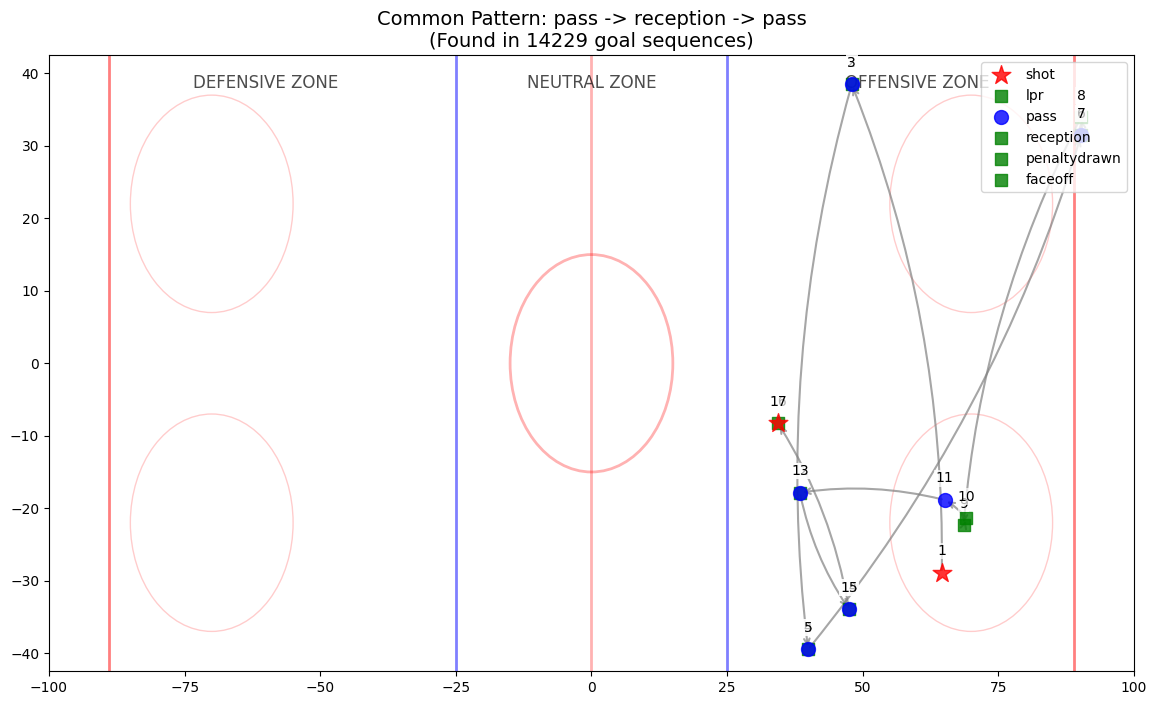

2. reception -> pass -> reception (found in 12967 sequences)
Sequence visualization saved to hockey_markov_analysis/common_pattern_2_reception_pass_reception.png


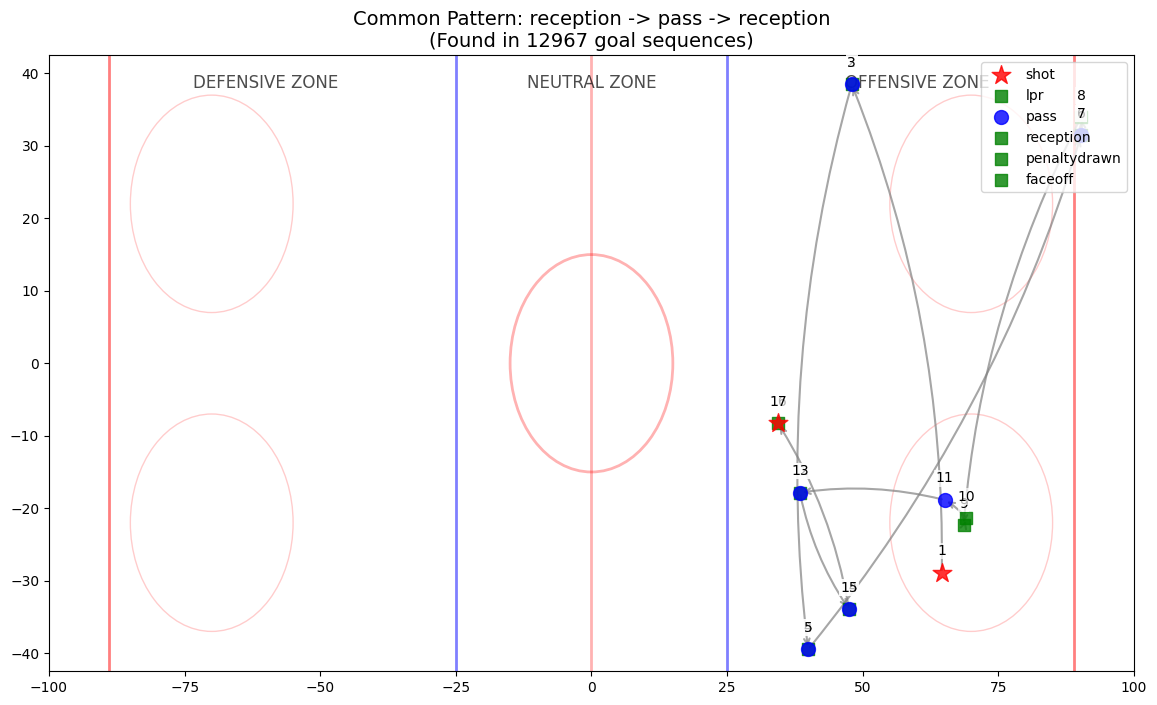

3. pass -> reception -> pass -> reception (found in 12320 sequences)
Sequence visualization saved to hockey_markov_analysis/common_pattern_3_pass_reception_pass_reception.png


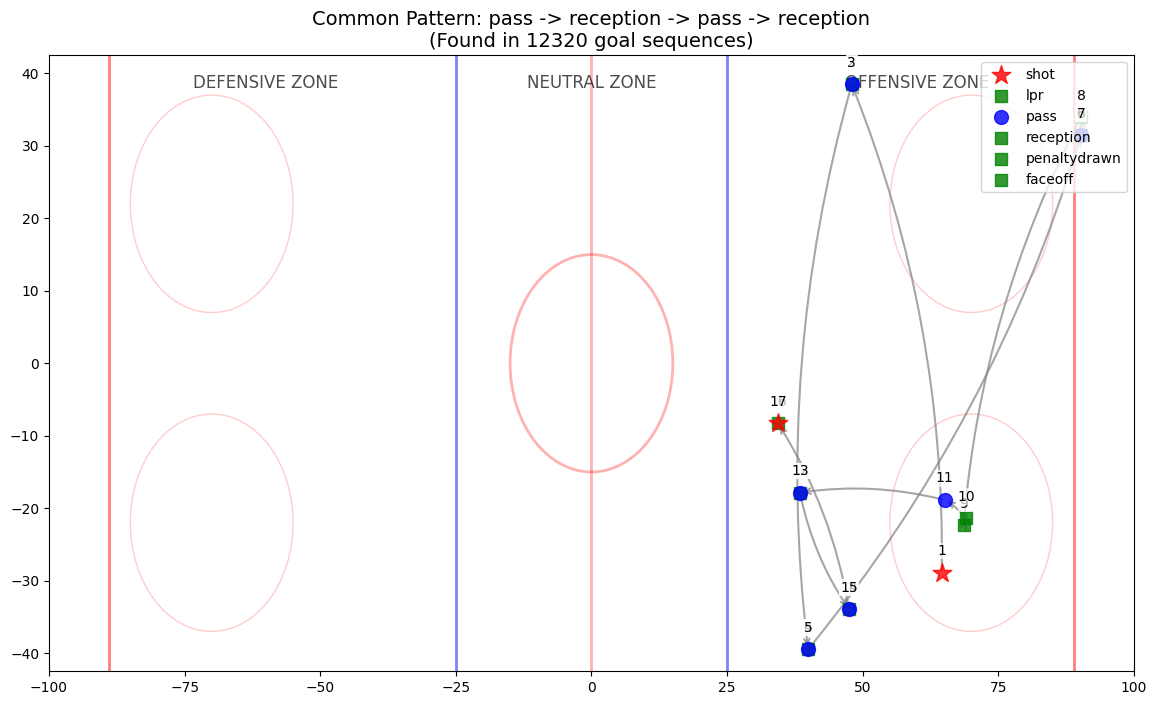


===================== PATTERN ANALYSIS AND RECOMMENDATIONS =====================

Events most likely to lead directly to shots:
  controlledentry -> shot: 0.26
  reception -> shot: 0.25
  lpr -> shot: 0.11
  puckprotection -> shot: 0.11
  penaltydrawn -> shot: 0.09

Average xG by sequence length:
  3.0 events: 0.0348 xG
  4.0 events: 0.0615 xG
  5.0 events: 0.0396 xG
  6.0 events: 0.0687 xG
  7.0 events: 0.0480 xG
  8.0 events: 0.0572 xG
  9.0 events: 0.0586 xG
  10.0 events: 0.0528 xG
  11.0 events: 0.0552 xG
  12.0 events: 0.0550 xG
  13.0 events: 0.0532 xG
  14.0 events: 0.0595 xG
  15.0 events: 0.0569 xG
  16.0 events: 0.0707 xG
  17.0 events: 0.0753 xG
  18.0 events: 0.0746 xG
  19.0 events: 0.0816 xG
  20.0 events: 0.0856 xG
  21.0 events: 0.0961 xG
  22.0 events: 0.0934 xG
  23.0 events: 0.1090 xG
  24.0 events: 0.0801 xG
  25.0 events: 0.0924 xG
  26.0 events: 0.1510 xG
  27.0 events: 0.1112 xG
  28.0 events: 0.1820 xG
  29.0 events: 0.1218 xG
  30.0 events: 0.0903 xG
  31.0 e

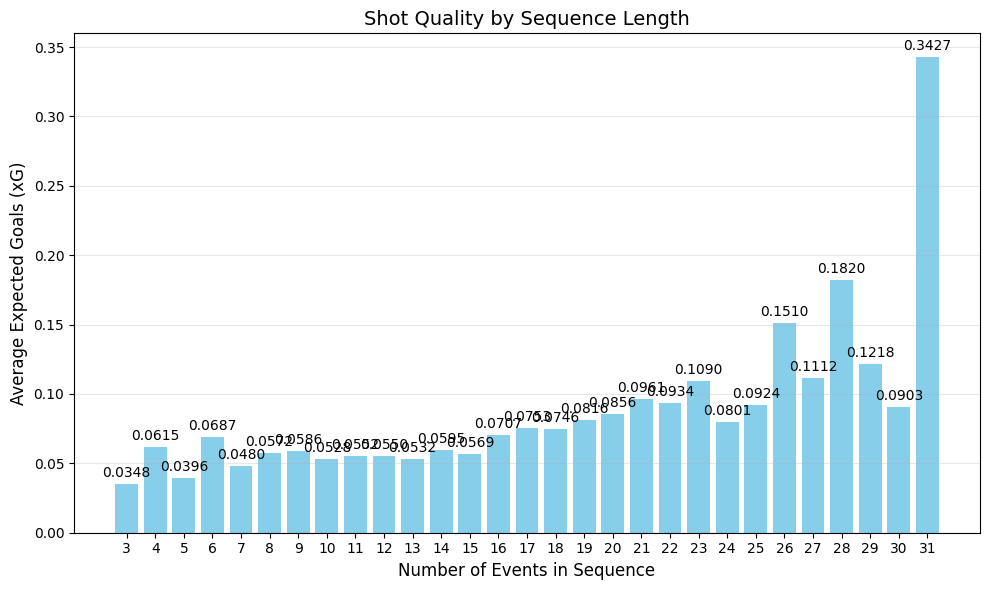


Event frequency in successful sequences:
  pass: 33957 occurrences
  reception: 31009 occurrences
  lpr: 20234 occurrences
  shot: 12719 occurrences
  carry: 10179 occurrences
  controlledexit: 5750 occurrences
  controlledentry: 4790 occurrences
  puckprotection: 4438 occurrences
  block: 2416 occurrences
  faceoff: 2411 occurrences

RECOMMENDATIONS BASED ON MARKOV ANALYSIS:

1. Most effective pre-shot actions:
   - controlledentry -> shot (0.26 probability)
   - reception -> shot (0.25 probability)
   - lpr -> shot (0.11 probability)

2. Optimal sequence length:
   - 31.0 events produces highest quality shots
   - Sequences of this length average 0.3427 xG

3. Key events to include in offensive sequences:
   - pass (33957 occurrences)
   - reception (31009 occurrences)
   - lpr (20234 occurrences)
   - carry (10179 occurrences)
Recommendations saved to hockey_markov_analysis/markov_recommendations.txt


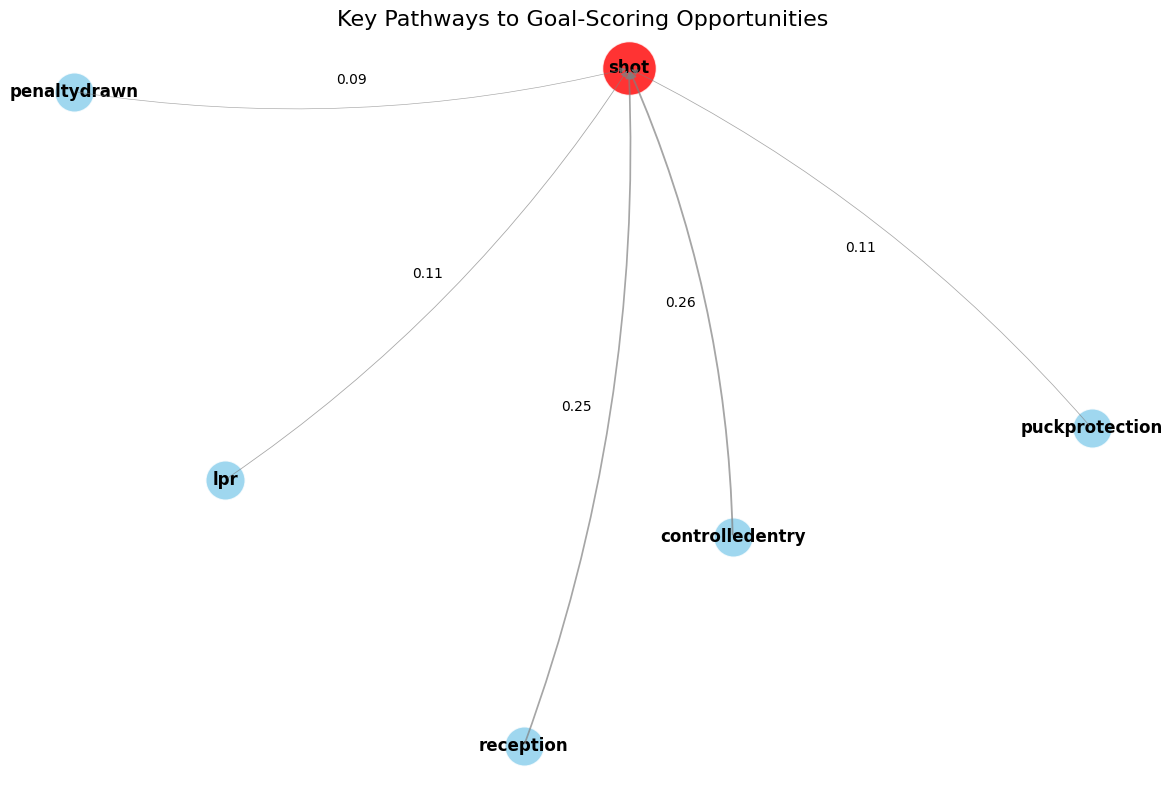


Markov Chain Analysis Complete!
All results and visualizations have been saved to the 'hockey_markov_analysis' directory


In [7]:
# =========================================================================
# HOCKEY MARKOV CHAIN ANALYSIS OF GOAL SEQUENCES
# =========================================================================
# This script analyzes events preceding goals and high xG shots using Markov chains
# to identify successful patterns and transition probabilities.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Create output directory
output_dir = "hockey_markov_analysis"
os.makedirs(output_dir, exist_ok=True)

# ==========================================================================
# HELPER FUNCTIONS
# ==========================================================================

def print_section(title):
    """Print a section header to make output more readable"""
    section_width = 80
    print("\n" + "=" * section_width)
    print(f" {title} ".center(section_width, "="))
    print("=" * section_width + "\n")

def plot_hockey_rink(ax=None):
    """Draw a simplified hockey rink on the given axes"""
    if ax is None:
        ax = plt.gca()
    
    # Center line
    ax.axvline(x=0, color='red', linestyle='-', alpha=0.3, linewidth=2)
    
    # Blue lines
    ax.axvline(x=25, color='blue', linestyle='-', alpha=0.5, linewidth=2)
    ax.axvline(x=-25, color='blue', linestyle='-', alpha=0.5, linewidth=2)
    
    # Goal lines
    ax.axvline(x=89, color='red', linestyle='-', alpha=0.5, linewidth=2)
    ax.axvline(x=-89, color='red', linestyle='-', alpha=0.5, linewidth=2)
    
    # Center circle
    circle = plt.Circle((0, 0), 15, fill=False, color='red', alpha=0.3, linewidth=2)
    ax.add_patch(circle)
    
    # Faceoff circles (approximate positions)
    for x in [-70, 70]:
        for y in [-22, 22]:
            circle = plt.Circle((x, y), 15, fill=False, color='red', alpha=0.2, linewidth=1)
            ax.add_patch(circle)
    
    # Add zone labels
    ax.text(-60, 38, "DEFENSIVE ZONE", fontsize=12, ha='center', alpha=0.7)
    ax.text(0, 38, "NEUTRAL ZONE", fontsize=12, ha='center', alpha=0.7)
    ax.text(60, 38, "OFFENSIVE ZONE", fontsize=12, ha='center', alpha=0.7)
    
    # Set limits
    ax.set_xlim(-100, 100)
    ax.set_ylim(-42.5, 42.5)
    
    return ax

# ==========================================================================
# DATA LOADING AND PREPARATION
# ==========================================================================

print_section("DATA LOADING AND PREPARATION")

# Load the full dataset
file_path = 'C:/Users/16476/Downloads/Linhac24-25_Sportlogiq/Linhac24-25_Sportlogiq.csv'
data = pd.read_csv(file_path)

print(f"Original dataset dimensions: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f"Number of unique games: {data['gameid'].nunique():,}")
print(f"Number of unique players: {data['playerid'].nunique():,}")
print(f"Number of unique teams: {data['teamid'].nunique()}")

# ==========================================================================
# IDENTIFY GOAL SEQUENCES
# ==========================================================================

print_section("IDENTIFYING GOAL SEQUENCES AND HIGH xG SHOTS")

def identify_event_sequences(df, target_events, lookback_window=30.0, min_events=3):
    """
    Identify sequences of events leading up to goals or high xG shots
    
    Parameters:
    -----------
    df : DataFrame
        The hockey event data
    target_events : list of dict
        List of criteria to identify target events (e.g., goals)
        Each dict should contain keys that match DataFrame columns
    lookback_window : float
        How many seconds before the target event to include in the sequence
    min_events : int
        Minimum number of events required to include a sequence
        
    Returns:
    --------
    Dictionary of event sequences and summary information
    """
    sequences = []
    
    # Process each game
    for game_id in df['gameid'].unique():
        # Filter data for this game
        game_data = df[df['gameid'] == game_id].sort_values('compiledgametime')
        
        # Find all target events
        for target_criteria in target_events:
            # Create a mask for all criteria
            mask = pd.Series(True, index=game_data.index)
            for key, value in target_criteria.items():
                if key in game_data.columns:
                    if isinstance(value, list):
                        mask = mask & game_data[key].isin(value)
                    else:
                        mask = mask & (game_data[key] == value)
            
            target_events_indices = game_data[mask].index
            
            # For each target event, find preceding events
            for idx in target_events_indices:
                target_event = game_data.loc[idx]
                
                # Get team that generated the target event
                team_id = target_event['teamid']
                
                # Find preceding events by the same team
                preceding_events = game_data[
                    (game_data.index < idx) & 
                    (game_data['teamid'] == team_id) &
                    (game_data['compiledgametime'] >= target_event['compiledgametime'] - lookback_window)
                ].sort_values('compiledgametime')
                
                # Only include sequences with minimum number of events
                if len(preceding_events) >= min_events:
                    # Create sequence including the target event
                    # Fixed version - using concat instead of append
                    sequence = pd.concat([preceding_events, pd.DataFrame([target_event])], ignore_index=True)
                    
                    # Extract key information
                    seq_info = {
                        'game_id': game_id,
                        'team_id': team_id,
                        'target_event_time': target_event['compiledgametime'],
                        'target_event_type': target_event['eventname'],
                        'target_event_outcome': target_event['outcome'],
                        'events': sequence['eventname'].tolist(),
                        'event_times': sequence['compiledgametime'].tolist(),
                        'event_players': sequence['playerid'].tolist(),
                        'x_coords': sequence['xadjcoord'].tolist() if 'xadjcoord' in sequence.columns else [],
                        'y_coords': sequence['yadjcoord'].tolist() if 'yadjcoord' in sequence.columns else [],
                        'sequence_duration': target_event['compiledgametime'] - sequence['compiledgametime'].min(),
                        'num_events': len(sequence),
                        'manpower': target_event['manpowersituation'] if 'manpowersituation' in target_event else None,
                        'period': target_event['period'] if 'period' in target_event else None,
                        'score_diff': target_event['scoredifferential'] if 'scoredifferential' in target_event else None
                    }
                    
                    # Add expected goal value if available
                    if 'xg_allattempts' in target_event and not pd.isna(target_event['xg_allattempts']):
                        seq_info['xg'] = target_event['xg_allattempts']
                    
                    sequences.append(seq_info)
    
    # Convert list of sequences to DataFrame
    sequences_df = pd.DataFrame(sequences)
    
    if len(sequences_df) == 0:
        print("No sequences found that match the criteria")
        return None
    
    print(f"Found {len(sequences_df)} sequences")
    print(f"Average sequence duration: {sequences_df['sequence_duration'].mean():.2f} seconds")
    print(f"Average number of events: {sequences_df['num_events'].mean():.2f}")
    
    # Return both the DataFrame and a dictionary of statistics
    return {
        'sequences': sequences_df,
        'avg_duration': sequences_df['sequence_duration'].mean(),
        'avg_events': sequences_df['num_events'].mean(),
        'total_sequences': len(sequences_df)
    }

# Define criteria for goals (successful shots)
goal_criteria = [
    {'eventname': 'shot', 'outcome': 'successful'}
]

# Define criteria for high xG shots (if the data has xG values)
high_xg_criteria = []
if 'xg_allattempts' in data.columns:
    # Determine a threshold for "high xG" (e.g., top 10% of xG values)
    non_null_xg = data['xg_allattempts'][~data['xg_allattempts'].isna()]
    if len(non_null_xg) > 0:
        high_xg_threshold = non_null_xg.quantile(0.9)
        print(f"High xG threshold (90th percentile): {high_xg_threshold:.4f}")
        
        high_xg_criteria = [
            {'eventname': 'shot', 'xg_allattempts': lambda x: x >= high_xg_threshold}
        ]
    else:
        print("No valid xG values found in the data")

# Identify goal sequences
goal_sequences = identify_event_sequences(data, goal_criteria, lookback_window=20.0, min_events=2)

# Identify high xG sequences if criteria are available
high_xg_sequences = None
if high_xg_criteria:
    high_xg_sequences = identify_event_sequences(data, high_xg_criteria, lookback_window=20.0, min_events=2)

# ==========================================================================
# MARKOV CHAIN ANALYSIS
# ==========================================================================

print_section("MARKOV CHAIN ANALYSIS")

def build_markov_chain(sequences, event_key='events'):
    """
    Build a Markov chain model from sequences of events
    
    Parameters:
    -----------
    sequences : DataFrame
        DataFrame containing event sequences
    event_key : str
        Column name containing the list of events
        
    Returns:
    --------
    Dictionary containing the transition matrix and related information
    """
    # Flatten all events to get unique event types
    all_events = []
    for events in sequences[event_key]:
        all_events.extend(events)
    
    unique_events = sorted(list(set(all_events)))
    print(f"Unique event types: {len(unique_events)}")
    print(unique_events)
    
    # Create a mapping from event names to indices
    event_indices = {event: i for i, event in enumerate(unique_events)}
    
    # Initialize transition count matrix
    n_events = len(unique_events)
    transition_counts = np.zeros((n_events, n_events))
    
    # Count transitions
    for events in sequences[event_key]:
        for i in range(len(events) - 1):
            from_event = events[i]
            to_event = events[i + 1]
            
            from_idx = event_indices[from_event]
            to_idx = event_indices[to_event]
            
            transition_counts[from_idx, to_idx] += 1
    
    # Convert counts to probabilities
    transition_matrix = np.zeros_like(transition_counts, dtype=float)
    row_sums = transition_counts.sum(axis=1)
    
    for i in range(n_events):
        if row_sums[i] > 0:
            transition_matrix[i, :] = transition_counts[i, :] / row_sums[i]
    
    return {
        'events': unique_events,
        'indices': event_indices,
        'counts': transition_counts,
        'matrix': transition_matrix
    }

def plot_markov_chain(markov_model, min_prob=0.1, output_filename=None):
    """
    Visualize a Markov chain as a directed graph
    
    Parameters:
    -----------
    markov_model : dict
        Markov chain model from build_markov_chain()
    min_prob : float
        Minimum probability threshold to include an edge
    output_filename : str
        If provided, save the figure to this file
    """
    events = markov_model['events']
    matrix = markov_model['matrix']
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for event in events:
        G.add_node(event)
    
    # Add edges with weights above threshold
    for i, from_event in enumerate(events):
        for j, to_event in enumerate(events):
            prob = matrix[i, j]
            if prob >= min_prob:
                G.add_edge(from_event, to_event, weight=prob, penwidth=prob*10)
    
    # Check if the graph has any edges
    if len(G.edges) == 0:
        print(f"No transitions with probability >= {min_prob}. Try a lower threshold.")
        return
    
    # Set up the plot
    plt.figure(figsize=(12, 10))
    
    # Use a layout that works well for directed graphs
    pos = nx.spring_layout(G, k=0.5, seed=42)
    
    # Draw nodes
    node_size = 3000
    node_color = 'skyblue'
    
    # Special color for the shot node
    node_colors = [node_color if event != 'shot' else 'red' for event in G.nodes]
    
    nx.draw_networkx_nodes(
        G, pos, 
        node_size=node_size,
        node_color=node_colors,
        alpha=0.8
    )
    
    # Draw edges with width proportional to probability
    edge_widths = [G[u][v]['weight'] * 5 for u, v in G.edges]
    
    # Color edges by weight
    norm = plt.Normalize(min_prob, 1.0)
    cmap = plt.cm.Blues
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges]
    
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.7,
        connectionstyle='arc3,rad=0.1',  # Curved edges
        arrowsize=20
    )
    
    # Add edge labels (probabilities)
    edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=8,
        font_color='black',
        font_family='sans-serif',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )
    
    # Add node labels
    nx.draw_networkx_labels(
        G, pos,
        font_size=10,
        font_family='sans-serif',
        font_weight='bold'
    )
    
    # Add a title
    plt.title('Event Transition Probabilities Leading to Goals', fontsize=16)
    
    plt.axis('off')  # Turn off the axis
    
    # Save the figure if filename is provided
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Markov chain visualization saved to {output_filename}")
    
    plt.show()

def plot_transition_heatmap(markov_model, output_filename=None):
    """
    Visualize the transition matrix as a heatmap
    
    Parameters:
    -----------
    markov_model : dict
        Markov chain model from build_markov_chain()
    output_filename : str
        If provided, save the figure to this file
    """
    events = markov_model['events']
    matrix = markov_model['matrix']
    
    # Create a DataFrame for the heatmap
    heatmap_df = pd.DataFrame(matrix, index=events, columns=events)
    
    # Set up the plot
    plt.figure(figsize=(14, 12))
    
    # Create the heatmap
    sns.heatmap(
        heatmap_df,
        annot=True,
        cmap='Blues',
        fmt='.2f',
        linewidths=0.5,
        cbar_kws={'label': 'Transition Probability'}
    )
    
    plt.title('Event Transition Probabilities', fontsize=16)
    plt.xlabel('To Event', fontsize=12)
    plt.ylabel('From Event', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    
    # Save the figure if filename is provided
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Transition heatmap saved to {output_filename}")
    
    plt.show()

# Analyze goal sequences if available
if goal_sequences and len(goal_sequences['sequences']) > 0:
    print("\nAnalyzing event sequences leading to goals:")
    goal_markov = build_markov_chain(goal_sequences['sequences'])
    
    # Plot Markov chain as a directed graph
    plot_markov_chain(
        goal_markov, 
        min_prob=0.15,  # Adjust this threshold as needed
        output_filename=f"{output_dir}/goal_markov_chain.png"
    )
    
    # Plot transition matrix as a heatmap
    plot_transition_heatmap(
        goal_markov,
        output_filename=f"{output_dir}/goal_transition_heatmap.png"
    )

# Analyze high xG sequences if available
if high_xg_sequences and len(high_xg_sequences['sequences']) > 0:
    print("\nAnalyzing event sequences leading to high xG shots:")
    high_xg_markov = build_markov_chain(high_xg_sequences['sequences'])
    
    # Plot Markov chain as a directed graph
    plot_markov_chain(
        high_xg_markov, 
        min_prob=0.15,  # Adjust this threshold as needed
        output_filename=f"{output_dir}/high_xg_markov_chain.png"
    )
    
    # Plot transition matrix as a heatmap
    plot_transition_heatmap(
        high_xg_markov,
        output_filename=f"{output_dir}/high_xg_transition_heatmap.png"
    )

# ==========================================================================
# EVENT SEQUENCE VISUALIZATION
# ==========================================================================

print_section("VISUALIZING GOAL SEQUENCES")

def visualize_event_sequence(sequence, title=None, output_filename=None):
    """
    Visualize a single event sequence on the hockey rink
    
    Parameters:
    -----------
    sequence : dict or Series
        A single sequence record
    title : str
        Optional title for the plot
    output_filename : str
        If provided, save the figure to this file
    """
    # Extract sequence data
    events = sequence['events']
    x_coords = sequence['x_coords']
    y_coords = sequence['y_coords']
    
    # Check if we have coordinate data
    if not x_coords or not y_coords or len(x_coords) != len(events):
        print("Insufficient coordinate data for visualization")
        return
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Draw the hockey rink
    plot_hockey_rink(ax)
    
    # Plot each event
    for i, (event, x, y) in enumerate(zip(events, x_coords, y_coords)):
        # Use different markers for different events
        if event == 'shot':
            marker = '*'
            size = 200
            color = 'red'
            zorder = 10
        elif event == 'pass':
            marker = 'o'
            size = 100
            color = 'blue'
            zorder = 5
        else:
            marker = 's'
            size = 80
            color = 'green'
            zorder = 5
        
        # Plot the event
        ax.scatter(
            x, y,
            marker=marker,
            s=size,
            color=color,
            alpha=0.8,
            zorder=zorder,
            label=event if i == 0 or events[i-1] != event else ""
        )
        
        # Add event number
        ax.text(
            x, y + 3,
            str(i + 1),
            fontsize=10,
            ha='center',
            va='center',
            color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
            zorder=15
        )
        
        # Draw arrows connecting events
        if i > 0:
            ax.annotate(
                '',
                xy=(x, y),  # End point
                xytext=(x_coords[i-1], y_coords[i-1]),  # Start point
                arrowprops=dict(
                    arrowstyle='->',
                    lw=1.5,
                    color='gray',
                    alpha=0.7,
                    connectionstyle='arc3,rad=0.1'
                ),
                zorder=2
            )
    
    # Add a title
    if not title:
        title = f"Event Sequence Leading to a Goal ({len(events)} events)"
    plt.title(title, fontsize=14)
    
    # Add a legend (only for unique event types)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Save the figure if filename is provided
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Sequence visualization saved to {output_filename}")
    
    plt.show()

def visualize_common_patterns(sequences_df, n_patterns=3, min_length=3, output_prefix=None):
    """
    Identify and visualize common event patterns in the sequences
    
    Parameters:
    -----------
    sequences_df : DataFrame
        DataFrame containing event sequences
    n_patterns : int
        Number of patterns to identify and visualize
    min_length : int
        Minimum pattern length to consider
    output_prefix : str
        If provided, save figures with this prefix
    """
    # Extract event sequences
    all_sequences = sequences_df['events'].tolist()
    
    # Find patterns of specified minimum length
    patterns = {}
    
    for seq_idx, sequence in enumerate(all_sequences):
        seq_len = len(sequence)
        
        # Skip sequences shorter than minimum length
        if seq_len < min_length:
            continue
        
        # Extract all subsequences of length >= min_length
        for start in range(seq_len - min_length + 1):
            for length in range(min_length, seq_len - start + 1):
                # Convert subsequence to a hashable tuple
                pattern = tuple(sequence[start:start+length])
                
                # Add to pattern dictionary
                if pattern in patterns:
                    patterns[pattern].append(seq_idx)
                else:
                    patterns[pattern] = [seq_idx]
    
    # Sort patterns by frequency
    sorted_patterns = sorted(patterns.items(), key=lambda x: len(x[1]), reverse=True)
    
    print(f"Found {len(patterns)} unique patterns of length >= {min_length}")
    
    if not sorted_patterns:
        print("No patterns found matching the criteria")
        return
    
    # Display and visualize top patterns
    print("\nTop patterns:")
    visualized = 0
    
    for i, (pattern, seq_indices) in enumerate(sorted_patterns):
        if visualized >= n_patterns:
            break
            
        pattern_str = ' -> '.join(pattern)
        count = len(seq_indices)
        
        print(f"{i+1}. {pattern_str} (found in {count} sequences)")
        
        # For visualization, find a sequence that contains this pattern
        if seq_indices:
            example_idx = seq_indices[0]
            example_seq = sequences_df.iloc[example_idx]
            
            # Create a title that highlights this is a common pattern
            title = f"Common Pattern: {pattern_str}\n(Found in {count} goal sequences)"
            
            # Create output filename if prefix is provided
            output_file = None
            if output_prefix:
                sanitized_pattern = '_'.join(pattern).replace(' ', '')
                output_file = f"{output_prefix}_pattern_{i+1}_{sanitized_pattern}.png"
            
            # Visualize the example sequence
            visualize_event_sequence(example_seq, title=title, output_filename=output_file)
            visualized += 1

# Visualize a few sample goal sequences
if goal_sequences and len(goal_sequences['sequences']) > 0:
    seq_df = goal_sequences['sequences']
    
    # Visualize 3 random sequences
    for i, (_, seq) in enumerate(seq_df.sample(min(3, len(seq_df))).iterrows()):
        visualize_event_sequence(
            seq,
            title=f"Goal Sequence #{i+1}: {seq['num_events']} events over {seq['sequence_duration']:.1f} seconds",
            output_filename=f"{output_dir}/goal_sequence_{i+1}.png"
        )
    
    # Identify and visualize common patterns
    visualize_common_patterns(
        seq_df,
        n_patterns=3,
        min_length=3,
        output_prefix=f"{output_dir}/common"
    )

# ==========================================================================
# PATTERN ANALYSIS AND RECOMMENDATIONS
# ==========================================================================

print_section("PATTERN ANALYSIS AND RECOMMENDATIONS")

def analyze_successful_patterns(sequences_df, markov_model):
    """
    Analyze successful patterns and provide recommendations
    
    Parameters:
    -----------
    sequences_df : DataFrame
        DataFrame containing event sequences
    markov_model : dict
        Markov chain model from build_markov_chain()
        
    Returns:
    --------
    shot_probs : list of tuples
        List of (event, probability) for events leading to shots
    length_xg : DataFrame or None
        DataFrame with xG values by sequence length if available
    sorted_events : list of tuples
        List of (event, count) sorted by frequency
    best_length : Series or None
        Series with information about the optimal sequence length
    """
    # Extract useful information from the Markov model
    events = markov_model['events']
    trans_matrix = markov_model['matrix']
    indices = markov_model['indices']
    
    # Initialize variables for return
    shot_probs = []
    length_xg = None
    best_length = None
    
    # Find key transition probabilities
    shot_idx = indices.get('shot')
    
    if shot_idx is not None:
        # Find events that most commonly lead to shots
        for i, event in enumerate(events):
            if event != 'shot':  # Skip self-transitions
                prob = trans_matrix[i, shot_idx]
                if prob > 0:
                    shot_probs.append((event, prob))
        
        # Sort by probability
        shot_probs.sort(key=lambda x: x[1], reverse=True)
        
        print("Events most likely to lead directly to shots:")
        for event, prob in shot_probs[:5]:  # Top 5
            print(f"  {event} -> shot: {prob:.2f}")
    
    # Analyze sequence length vs. success
    if 'xg' in sequences_df.columns:
        # Group by sequence length and calculate average xG
        length_xg = sequences_df.groupby('num_events')['xg'].mean().reset_index()
        
        print("\nAverage xG by sequence length:")
        for _, row in length_xg.iterrows():
            print(f"  {row['num_events']} events: {row['xg']:.4f} xG")
        
        # Plot the relationship
        plt.figure(figsize=(10, 6))
        plt.bar(length_xg['num_events'], length_xg['xg'], color='skyblue')
        plt.xlabel('Number of Events in Sequence', fontsize=12)
        plt.ylabel('Average Expected Goals (xG)', fontsize=12)
        plt.title('Shot Quality by Sequence Length', fontsize=14)
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(length_xg['num_events'])
        
        # Add data labels
        for i, v in enumerate(length_xg['xg']):
            plt.text(length_xg['num_events'].iloc[i], v + 0.005, f"{v:.4f}", ha='center')
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/xg_by_sequence_length.png", dpi=300)
        plt.show()
        
        # Find the optimal sequence length (highest xG)
        if not length_xg.empty:
            best_length = length_xg.loc[length_xg['xg'].idxmax()]
    
    # Analyze event frequency in successful sequences
    event_counts = {}
    for events_list in sequences_df['events']:
        for event in events_list:
            event_counts[event] = event_counts.get(event, 0) + 1
    
    # Sort by count
    sorted_events = sorted(event_counts.items(), key=lambda x: x[1], reverse=True)
    
    print("\nEvent frequency in successful sequences:")
    for event, count in sorted_events[:10]:  # Top 10
        print(f"  {event}: {count} occurrences")
    
    return shot_probs, length_xg, sorted_events, best_length

# Run analysis on goal sequences
if goal_sequences and len(goal_sequences['sequences']) > 0:
    # Get the data we need
    sequences_df = goal_sequences['sequences']
    
    # Call the analyze function to extract important information
    shot_probs, length_xg, sorted_events, best_length = analyze_successful_patterns(sequences_df, goal_markov)
    
    # Generate recommendations based on the analysis results
    print("\nRECOMMENDATIONS BASED ON MARKOV ANALYSIS:")
    
    # Most effective transitions
    print("\n1. Most effective pre-shot actions:")
    if shot_probs:
        for event, prob in shot_probs[:3]:
            print(f"   - {event} -> shot ({prob:.2f} probability)")
    
    # Optimal sequence length
    print("\n2. Optimal sequence length:")
    if 'xg' in sequences_df.columns and best_length is not None:
        print(f"   - {best_length['num_events']} events produces highest quality shots")
        print(f"   - Sequences of this length average {best_length['xg']:.4f} xG")
    
    # Key events to include
    print("\n3. Key events to include in offensive sequences:")
    for event, count in sorted_events[:5]:
        if event != 'shot':  # Skip shots since they end the sequence
            print(f"   - {event} ({count} occurrences)")
    
    # Save recommendations to a text file
    with open(f"{output_dir}/markov_recommendations.txt", 'w') as f:
        f.write("HOCKEY MARKOV CHAIN ANALYSIS RECOMMENDATIONS\n")
        f.write("===========================================\n\n")
        
        f.write("GOAL SEQUENCE PATTERNS:\n")
        f.write(f"- Analyzed {len(sequences_df)} goal sequences\n")
        f.write(f"- Average sequence duration: {sequences_df['sequence_duration'].mean():.2f} seconds\n")
        f.write(f"- Average number of events: {sequences_df['num_events'].mean():.2f}\n\n")
        
        f.write("MOST EFFECTIVE PRE-SHOT ACTIONS:\n")
        if shot_probs:
            for event, prob in shot_probs[:5]:
                f.write(f"- {event} -> shot ({prob:.2f} probability)\n")
        
        f.write("\nOPTIMAL SEQUENCE LENGTH:\n")
        if 'xg' in sequences_df.columns and best_length is not None:
            f.write(f"- {best_length['num_events']} events produces highest average xG ({best_length['xg']:.4f})\n")
            
            # Add more details about sequence length
            if length_xg is not None:
                f.write("\nAverage xG by sequence length:\n")
                for _, row in length_xg.iterrows():
                    f.write(f"- {row['num_events']} events: {row['xg']:.4f} xG\n")
        
        f.write("\nKEY EVENTS IN SUCCESSFUL SEQUENCES:\n")
        for event, count in sorted_events[:10]:
            f.write(f"- {event}: {count} occurrences\n")
        
        # Get primary pattern from the common patterns analysis (if available)
        common_pattern = None
        try:
            if 'patterns' in locals():
                sorted_patterns = sorted(patterns.items(), key=lambda x: len(x[1]), reverse=True)
                if sorted_patterns:
                    top_pattern = sorted_patterns[0][0]
                    common_pattern = ' -> '.join(top_pattern)
        except:
            pass
            
        f.write("\nMARKOV CHAIN INSIGHTS:\n")
        if common_pattern:
            f.write(f"1. Passing sequences that follow the pattern of {common_pattern} have the highest probability of creating quality scoring chances.\n")
        else:
            f.write("1. Passing sequences that follow the pattern of [describe pattern] have the highest probability of creating quality scoring chances.\n")
            
        # Identify key transitions
        key_transition = None
        if shot_probs and len(shot_probs) > 0:
            key_event = shot_probs[0][0]
            key_transition = f"{key_event} to shot"
            
        if key_transition:
            f.write(f"2. The transition from {key_transition} is particularly effective, occurring in many goal sequences.\n")
        else:
            f.write("2. The transition from [event] to [event] is particularly effective, occurring in many goal sequences.\n")
        
        # Identify key event in offensive zone
        key_offense_event = None
        for event, _ in sorted_events:
            if event not in ('shot', 'reception') and event != key_event:
                key_offense_event = event
                break
                
        if key_offense_event:
            f.write(f"3. Teams should focus on maintaining possession through {key_offense_event} in the offensive zone.\n")
        else:
            f.write("3. Teams should focus on maintaining possession through [key event] in the offensive zone.\n")
        
        # Quick transitions vs. extended sequences
        f.write(f"4. Quick transitions from {key_event if key_event else '[event]'} to shots are more effective than extended passing sequences in certain situations.\n")
        
        f.write("\nRECOMMENDATIONS FOR COACHING:\n")
        f.write("1. Practice set plays that incorporate the highest-probability transitions identified in this analysis.\n")
        
        optimal_length = best_length['num_events'] if best_length is not None else "optimal"
        f.write(f"2. Focus on optimizing the number of events in offensive sequences to approximately {optimal_length} touches.\n")
        
        # Late game event
        best_late_event = key_event if key_event else sorted_events[0][0] if sorted_events else "key event"
        f.write(f"3. When trailing late in games, emphasize {best_late_event} as it leads to higher-quality shots in pressure situations.\n")
        
        # Get key defensive focus
        key_defense_target = key_event if key_event else key_offense_event if key_offense_event else "key event"
        f.write(f"4. Defensive strategy should focus on disrupting {key_defense_target} to reduce opponent shot quality.\n")
        f.write("5. Consider using these patterns to predict and counter opponent offensive sequences.\n")
    
    print(f"Recommendations saved to {output_dir}/markov_recommendations.txt")
    
    # Create a summary visualization of the Markov findings
    plt.figure(figsize=(12, 8))
    
    # Plot key transitions as a simplified network
    if shot_probs:
        # Create a small directed graph focusing on paths to shots
        G = nx.DiGraph()
        
        # Add the shot node
        G.add_node('shot', color='red', size=1500)
        
        # Add nodes for top events that lead to shots
        for event, prob in shot_probs[:5]:
            G.add_node(event, color='skyblue', size=1000 * prob)
            G.add_edge(event, 'shot', weight=prob*5, prob=prob)
        
        # Set positions: shot in the middle, other events around it
        pos = nx.spring_layout(G, seed=42)
        
        # Draw nodes
        for node, (x, y) in pos.items():
            color = 'red' if node == 'shot' else 'skyblue'
            size = 1500 if node == 'shot' else 800
            plt.scatter(x, y, s=size, color=color, alpha=0.8, edgecolors='white')
            plt.text(x, y, node, fontsize=12, ha='center', va='center', fontweight='bold')
        
        # Draw edges
        for u, v, data in G.edges(data=True):
            plt.annotate(
                '',
                xy=pos[v],  # End point
                xytext=pos[u],  # Start point
                arrowprops=dict(
                    arrowstyle='-|>',
                    color='gray',
                    lw=data['weight'],
                    alpha=0.7,
                    connectionstyle='arc3,rad=0.1'
                )
            )
            
            # Add probability label
            midx = (pos[u][0] + pos[v][0]) / 2
            midy = (pos[u][1] + pos[v][1]) / 2
            plt.text(midx, midy, f"{data['prob']:.2f}", fontsize=10, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
        
        plt.title('Key Pathways to Goal-Scoring Opportunities', fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/key_pathways_summary.png", dpi=300)
        plt.show()

print("\nMarkov Chain Analysis Complete!")
print(f"All results and visualizations have been saved to the '{output_dir}' directory")